# Lab4: Quantize DeiT

### Setup

Install the newest version of torch, torchvision, and timm.

In [ ]:
# install the newest version of torch, torchvision, and timm
!pip3 uninstall --yes torch torchaudio torchvision torchtext torchdata timm
!pip3 install torch torchaudio torchvision torchtext torchdata timm

Import Required Libraries

In [1]:
import numpy as np
import torch
from torch import nn
import os
from tqdm.auto import tqdm
import math
import time

from torchvision import datasets, transforms
from timm.data import create_transform
from timm.data.constants import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD
from torch.utils.data import DataLoader

from torch.export import export, ExportedProgram
from torchvision.models.mobilenetv2 import MobileNet_V2_Weights
from torch._export import capture_pre_autograd_graph
from torch.ao.quantization.quantize_pt2e import convert_pt2e, prepare_pt2e, prepare_qat_pt2e
from torch.ao.quantization.quantizer.xnnpack_quantizer import (
    get_symmetric_quantization_config,
    XNNPACKQuantizer,
)

torch.cuda.is_available()

/home/pairlab/anaconda3/envs/EdgeAI/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


True

Preparing Dataset

In [2]:
def data_loader_to_list(data_loader, length=128):
    new_data_loader = []
    if length < 0:
        return list(data_loader)
    else:
        for i, data in enumerate(data_loader):
            if i >= length:
                break
            new_data_loader.append(data)

    return new_data_loader

def build_dataset_CIFAR100(is_train, data_path):
    transform = build_transform(is_train)
    dataset = datasets.CIFAR100(data_path, train=is_train, transform=transform, download=True)
    nb_classes = 100
    return dataset, nb_classes

def build_transform(is_train):
    input_size = 224
    eval_crop_ratio = 1.0

    resize_im = input_size > 32
    if is_train:
        # this should always dispatch to transforms_imagenet_train
        transform = create_transform(
            input_size=input_size,
            is_training=True,
            color_jitter=0.3,
            auto_augment='rand-m9-mstd0.5-inc1',
            interpolation='bicubic',
            re_prob=0.0,
            re_mode='pixel',
            re_count=1,
        )
        if not resize_im:
            # replace RandomResizedCropAndInterpolation with
            # RandomCrop
            transform.transforms[0] = transforms.RandomCrop(
                input_size, padding=4)
        return transform

    t = []
    if resize_im:
        size = int(input_size / eval_crop_ratio)
        t.append(
            transforms.Resize(size, interpolation=3),  # to maintain same ratio w.r.t. 224 images
        )
        t.append(transforms.CenterCrop(input_size))

    t.append(transforms.ToTensor())
    t.append(transforms.Normalize(IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD))
    return transforms.Compose(t)

def prepare_data(batch_size):
    train_set, nb_classes = build_dataset_CIFAR100(is_train=True, data_path='./data')
    test_set, _ = build_dataset_CIFAR100(is_train=False, data_path='./data')

    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=8)
    test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, drop_last=True, num_workers=8)
    return train_loader, test_loader, nb_classes


Training and Calibration

In [3]:
def calibrate(model: nn.Module, data_loader) -> None:
    calibration_data = data_loader_to_list(data_loader, math.ceil(128/data_loader.batch_size)) # calibrate 128 images
    for image, _ in calibration_data:
        model(image)
    return

def train_one_epoch(model, criterion, optimizer, data_loader, device):
    cnt = 0
    for image, target in tqdm(data_loader):
        cnt += 1
        image, target = image.to(device), target.to(device)
        output = model(image)
        loss = criterion(output, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

Evaluation

In [4]:
def get_size_of_model(model):
    torch.save(model.state_dict(), "temp.p")
    model_size = os.path.getsize("temp.p")/1e6
    os.remove('temp.p')
    return model_size

def evaluate_model(model, data_loader, device):
    model.to(device)
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in tqdm(data_loader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Accuracy of the model on the test images: {accuracy}%')
    return accuracy

def getMiniTestDataset():
    # Create a test_loader with batch size = 1
    _, test_loader, _ = prepare_data(batch_size=1)

    # Prepare to collect 10 images per class
    class_images = [[] for _ in range(100)]

    # Iterate through the data
    for (image, label) in test_loader:
        if len(class_images[label]) < 5:
            class_images[label].append((image, label))
        if all(len(images) == 5 for images in class_images):
            break  # Stop once we have 10 images per class

    # flatten class_images
    mini_test_dataset = []
    for images in class_images:
        mini_test_dataset.extend(images)
    return mini_test_dataset

# TA Uses the following code to evaluate your score
def lab4_cifar100_evaluation(quantized_model_path='deits_quantized.pth'):
    # Prepare data
    mini_test_dataset = getMiniTestDataset()

    # Load quantized model
    quantized_ep = torch.export.load(quantized_model_path)
    quantized_model = quantized_ep.module()

    # Evaluate model
    start_time = time.time()
    acc = evaluate_model(quantized_model, mini_test_dataset, device="cpu")
    exec_time = time.time() - start_time
    model_size = get_size_of_model(quantized_model)

    print(f"Model Size: {model_size:.2f} MB")
    print(f"Accuracy: {acc:.2f}%")
    print(f"Execution Time: {exec_time:.2f} s")

    score = 0
    if model_size <= 30: score += 10
    if model_size <= 27: score += 2 * math.floor(27-model_size)
    if acc >= 86:
      score += 10 + 2 * math.floor(acc-86)
    print(f'Model Score: {score:.2f}')
    return score

## Part1: Simple Quantization Pipeline (0%)

Below is a naive pipeline of quantizing DeiT-S. You may need to modify the pipeline or build your own later on.

[**use_reference_representation=False** in **convert_pt2e()** represents fake quant (matmul using fp32).](https://pytorch.org/tutorials/prototype/pt2e_quant_ptq_static.html#convert-the-calibrated-model-to-a-quantized-model)

However when the variable is set to True, the execution speed becomes extremely slow.

In this lab, it is just fine to set **use_reference_representation=False**.

In [5]:
from torch.export import Dim
from torch._export import capture_pre_autograd_graph

def quantize_ptq_model(model: nn.Module, data_loader, per_channel=False) -> None:
    # captuer model graph
    _dummy_input_data = (next(iter(data_loader))[0],)
    model.eval()
    dynamic_shapes = {"x": {0: Dim("batch")}} # to allow diffent batch size on training/inference
    model = capture_pre_autograd_graph(model, _dummy_input_data, dynamic_shapes=dynamic_shapes)

    # Init quantizer
    quantizer = XNNPACKQuantizer()
    quantization_config = get_symmetric_quantization_config(is_per_channel=per_channel, is_qat=False)
    quantizer.set_global(quantization_config)

    # Prepare model for quantization
    model = prepare_pt2e(model, quantizer)

    # Calibration
    calibrate(model, data_loader)

    # Convert model to quantized model
    model = convert_pt2e(model, use_reference_representation=False)
    return model

In [50]:
# Load the model
batch_size = 32 # Use batch size > 1 for faster PTQ and QAT.
model = torch.load('0.9099_deit3_small_patch16_224.pth', map_location='cpu')
train_loader, test_loader, nb_classes = prepare_data(batch_size)

# We use only a porpotion of test dataset for evaluation, with batch size = 1 for inference.
mini_test_dataset = getMiniTestDataset()

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [51]:
# evaluate before quantization
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
acc = evaluate_model(model, mini_test_dataset, device)
print('Size (MB) before quantization:', get_size_of_model(model))
print(f'Accuracy of the model on the test images: {acc}%') # 92.8%

# quantize model
print('Quantizing model...')
model.cpu()
prepared_model = quantize_ptq_model(model, train_loader, per_channel=False)
torch.ao.quantization.move_exported_model_to_eval(prepared_model)

print('Exporting model...')
quantized_model_path = "deits_quantized.pth"

prepared_model.cpu()
cpu_example_inputs = (torch.randn([1, 3, 224, 224]), ) # batch_size should equal to 1 on inference.
quantized_ep = torch.export.export(prepared_model, cpu_example_inputs)
torch.export.save(quantized_ep, quantized_model_path)

print('Evaluating model...')
lab4_cifar100_evaluation(quantized_model_path) # 84.4%

100%|██████████| 500/500 [00:01<00:00, 433.94it/s]


Accuracy of the model on the test images: 93.6%
Size (MB) before quantization: 86.905654
Accuracy of the model on the test images: 93.6%
Quantizing model...
Exporting model...
Evaluating model...
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 500/500 [00:27<00:00, 18.50it/s]

Accuracy of the model on the test images: 83.8%
Model Size: 21.94 MB
Accuracy: 83.80%
Execution Time: 27.03 s
Model Score: 20.00


20

# Below are some tools that may be useful in this lab:

## Profiling Models

The code below profiles your model, and generates a trace file for you to find out what is going on in your model throughout the execution.

The generated trace file will be named *(test_trace_*.json)*, in the same directory as the notebook. To visualize, go to page [chrome://tracing](chrome://tracing) in either Chrome or Edge browser, then upload the trace file.

In [6]:
# profile model
from torch.profiler import profile, record_function, ProfilerActivity

# ## Default way to use profiler
# with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA]) as prof:
#     for _ in range(10):
#         a = torch.square(torch.randn(10000, 10000).cuda())

# prof.export_chrome_trace("trace.json")

def torch_profile(model, input_data, device):
  ## With warmup and skip
  # https://pytorch.org/docs/stable/profiler.html

  # Non-default profiler schedule allows user to turn profiler on and off
  # on different iterations of the training loop;
  # trace_handler is called every time a new trace becomes available
  def trace_handler(prof):
    print(prof.key_averages().table(sort_by="self_cuda_time_total", row_limit=-1))
    prof.export_chrome_trace("./test_trace_" + str(prof.step_num) + ".json")

  with torch.profiler.profile(
    activities=[
      torch.profiler.ProfilerActivity.CPU,
      torch.profiler.ProfilerActivity.CUDA,
    ],

    # In this example with wait=1, warmup=1, active=2, repeat=1,
    # profiler will skip the first step/iteration,
    # start warming up on the second, record
    # the third and the forth iterations,
    # after which the trace will become available
    # and on_trace_ready (when set) is called;
    # the cycle repeats starting with the next step
    schedule=torch.profiler.schedule(wait=1, warmup=1, active=2, repeat=1),
    on_trace_ready=trace_handler
    # on_trace_ready=torch.profiler.tensorboard_trace_handler('./log')
    # used when outputting for tensorboard
    ) as p:
      for data in input_data:
        model(data.to(device))
        # send a signal to the profiler that the next iteration has started
        p.step()

In [ ]:
dummy_input_data = [next(iter(test_loader))[0] for _ in range(3)]
device = torch.device("cpu")

# profile quantized model
torch_profile(loaded_quantized_model, dummy_input_data, device)

## To obtain specific model layers

In [7]:
def match_string(string, match_list, match_prefix=False, match_suffix=False):
    if match_prefix:
        return any(string.startswith(s) for s in match_list)
    elif match_suffix:
        return any(string.endswith(s) for s in match_list)
    else:
        return any(s == string for s in match_list)

def get_model_layers(model, match_names=None, match_types=None, prefix=''):
    matching_layers = []
    for name, module in model.named_modules():
        if match_names is None or match_string(name, match_names):
            if match_types is None or match_string(type(module).__name__, match_types):
                matching_layers.append((f'{prefix}{name}', module))
    return matching_layers

# layer_names = [f'blocks.0.attn.qkv', f'blocks.0.mlp.fc1', f'blocks.0.mlp.fc2']
# block0_layers = get_model_layers(model, match_names=layer_names, match_types=['Linear'])

# print(block0_layers)

## To capture the output of each layer


In [8]:
class HookHandler:
    def __init__(self):
        self.handlers = []

    def __del__(self):
        self.remove_hooks()

    def _generate_hook(self, apply_func, key, layer_data_dict: dict):
        def hook_fn(model, input, output):
            nonlocal layer_data_dict
            layer_data_dict[key] = apply_func(
                output, layer_data_dict.get(key, None))
        return hook_fn

    def _bind_hooks(self, apply_layers, apply_func, layer_data_dict: dict):
        for name, module in apply_layers:
            hook_fn = self._generate_hook(apply_func, name, layer_data_dict)
            self.handlers.append(module.register_forward_hook(hook_fn))

    def create_hooks(self, apply_layers, apply_func, layer_data_dict: dict):
        self._bind_hooks(apply_layers, apply_func, layer_data_dict)

    def remove_hooks(self):
        for handle in self.handlers:
            handle.remove()
        self.handlers = []

def absmax(data, axis=None):
    p_data = data.max(axis=axis)
    n_data = data.min(axis=axis)
    return np.where(abs(p_data) > abs(n_data), p_data, n_data)

def get_flat_act_func(new_val: torch.Tensor, _):
    return new_val.cpu().detach().numpy().flatten()


def get_act_func(new_val: torch.Tensor, _):
    return new_val.cpu().detach().numpy()


def get_avg_act_func(new_val: torch.Tensor, existing_val):
    if existing_val is None:
        total_cnt = new_val.shape[0]
        avg = new_val.cpu().detach().numpy().sum(axis=0) / total_cnt

    else:
        total_cnt, avg = existing_val.get("total_cnt"), existing_val.get("value")
        avg = (avg * total_cnt + new_val.cpu().detach().numpy().sum(axis=0)) / (total_cnt + new_val.shape[0])
        total_cnt += new_val.shape[0]

    return {"total_cnt": total_cnt, "value": avg}

def get_absmax_act_func(new_val: torch.Tensor, existing_val):
    new_absmax = absmax(new_val.cpu().detach().numpy(), axis=0)
    if existing_val is None:
        value = new_absmax
    else:
        value = absmax(np.stack([existing_val, new_absmax], axis=0), axis=0)
    return value

In [ ]:
# initialize HookHandler and the dictionary to store the outputs
handler = HookHandler()
layer_outputs = {}

# get the layers you want to record
layer_names = [f'blocks.0.attn.qkv', f'blocks.0.mlp.fc1', f'blocks.0.mlp.fc2']
block0_layers = get_model_layers(model, match_names=layer_names, match_types=['Linear'])

# create hooks for the layers (<layers>, <hook function>, <dictionary to store the outputs>)
handler.create_hooks(block0_layers, get_act_func, layer_outputs)

# calibrate the model and record the outputs
with torch.autocast(device_type="cuda"):
    for i, (image, _) in enumerate(train_loader):
        if i >= 128: break
        model(image)

# remove the hooks
handler.remove_hooks()

print(layer_outputs)

## To ignore specific layers for quantization:
([xnnpack source code](https://github.com/pytorch/pytorch/blob/main/torch/ao/quantization/quantizer/xnnpack_quantizer.py\), also you can try messing around with the Observer classes)

In [9]:
# Replace functions XNNPackQuantizer uses for annotation.

def get_module_names(name):
    names = name.split(".")
    return [".".join(names[i:]) for i in reversed(range(len(names)))]

def parse_string(name):
    if name.startswith("L"): return name[10:]
    split_getattr = name.split(")")
    ig_left = split_getattr[0].split("L['self'].")[-1].split(",")[0]
    ig_right = split_getattr[0].split(", '")[-1][:-1]
    return ig_left + "." + str(ig_right) + split_getattr[1]

def is_name_in_ignore_list(name, IGNORE_LIST):
    return name in IGNORE_LIST

def name_not_in_ignore_list(n, IGNORE_LIST) -> bool:
    nn_module_stack = n.meta.get("nn_module_stack", {})
    names = [n for n, klass in nn_module_stack.values()]
    if len(names) == 0:
        return True

    names = get_module_names(parse_string(names[-1]))
    set1 = set(names)
    set2 = set(IGNORE_LIST)
    # if len(set1.intersection(set2)) == 0:
    #     print("DEBUG: ", names)
    return len(set1.intersection(set2)) == 0

def get_module_name_filter(module_name: str, IGNORE_LIST):
    def module_name_filter(n) -> bool:
        nn_module_stack = n.meta.get("nn_module_stack", {})
        names = [n for n, klass in nn_module_stack.values()]
        if len(names) == 0:
            return False

        names = get_module_names(parse_string(names[-1]))
        return (module_name in names) and name_not_in_ignore_list(n, IGNORE_LIST)
    return module_name_filter


def get_module_type_filter(tp, IGNORE_LIST):
    def module_type_filter(n) -> bool:
        nn_module_stack = n.meta.get("nn_module_stack", {})
        types = [t for _, t in nn_module_stack.values()]
        return (tp in types) and name_not_in_ignore_list(n, IGNORE_LIST)

    return module_type_filter


def get_not_module_type_or_name_filter(
    tp_list, module_name_list, IGNORE_LIST
):
    module_type_filters = [get_module_type_filter(tp) for tp in tp_list]
    module_name_list_filters = [get_module_name_filter(m) for m in module_name_list]

    def not_module_type_or_name_filter(n) -> bool:
        return not any(f(n) for f in module_type_filters + module_name_list_filters) and name_not_in_ignore_list(n, IGNORE_LIST)

    return not_module_type_or_name_filter

class PartialXNNPACKQuantizer(XNNPACKQuantizer): # skips quantizing layers inside the ignore_list
    def __init__(self, ignore_list):
        super().__init__()
        self.ignore_list = ignore_list

    def _annotate_for_static_quantization_config(
        self, model: torch.fx.GraphModule
    ) -> torch.fx.GraphModule:
        print("annotating for static quantization")
        module_name_list = list(self.module_name_config.keys())
        for module_name, config in self.module_name_config.items():
            self._annotate_all_static_patterns(
                model, config, get_module_name_filter(module_name, self.ignore_list)
            )

        tp_list = list(self.module_type_config.keys())
        for module_type, config in self.module_type_config.items():
            self._annotate_all_static_patterns(
                model, config, get_module_type_filter(module_type, self.ignore_list)
            )

        self._annotate_all_static_patterns(
            model,
            self.global_config,
            get_not_module_type_or_name_filter(tp_list, module_name_list, self.ignore_list),
        )
        return model

    def _annotate_for_dynamic_quantization_config(
        self, model: torch.fx.GraphModule
    ) -> torch.fx.GraphModule:
        print("annotating for dynamic quantization")
        module_name_list = list(self.module_name_config.keys())
        for module_name, config in self.module_name_config.items():
            self._annotate_all_dynamic_patterns(
                model, config, get_module_name_filter(module_name, self.ignore_list)
            )

        tp_list = list(self.module_type_config.keys())
        for module_type, config in self.module_type_config.items():
            self._annotate_all_dynamic_patterns(
                model, config, get_module_type_filter(module_type, self.ignore_list)
            )

        self._annotate_all_dynamic_patterns(
            model,
            self.global_config,
            get_not_module_type_or_name_filter(tp_list, module_name_list, self.ignore_list),
        )
        return model

# quantizer = XNNPACKQuantizer()
# quantizer = PartialXNNPACKQuantizer(ignore_list=["head"]) # replace XNNPACKQuantizer()

# Analysis

In [10]:
import copy
import matplotlib.pyplot as plt
from typing import Callable
from timm.models import VisionTransformer
from torch.export import ExportedProgram
from torch.fx import GraphModule, Graph
import torch.ao.quantization

plt.style.use("tableau-colorblind10")

In [11]:
batch_size = 32
quantized_model_path = "deits_quantized.pth"

train_loader, test_loader, nb_classes = prepare_data(batch_size)

model: VisionTransformer = torch.load('0.9099_deit3_small_patch16_224.pth', map_location='cpu')
quantized_ep: ExportedProgram = torch.export.load(quantized_model_path)
prepared_model = quantized_ep.module()

model.eval()
model.requires_grad_(False)
torch.ao.quantization.move_exported_model_to_eval(prepared_model)
prepared_model.requires_grad_(False)

Files already downloaded and verified
Files already downloaded and verified


GraphModule()

In [15]:
def hist_of_weight_channels(name: str, tensor: torch.Tensor, n_subplot: int = 8) -> None:
    tensor = tensor.detach().cpu()
    n_channel = tensor.size(0)
    plot_step = max(n_channel // n_subplot, 1)

    f, axes = plt.subplots(1, n_subplot, figsize=(12, 1.2))
    f.suptitle(name, fontsize=8)
    for i, ch in enumerate(range(0, n_channel // n_subplot * n_subplot, plot_step)):
        axes[i].tick_params("both", labelsize=5)
        axes[i].hist(tensor[ch].flatten(), 50)
    
    plt.plot()

def hist_of_weight_values(name: str, tensor: torch.Tensor, ax, max_val: float | None = None) -> None:
    tensor = tensor.detach().cpu().flatten()
    bins = np.linspace(tensor.min().item() if max_val is None else -max_val, tensor.max().item() if max_val is None else max_val, 200)
    ax.set_title(name, fontsize=6, y=1.0, pad=-7)
    ax.tick_params("both", labelsize=5)
    ax.hist(tensor, bins, alpha=0.5, color="blue")

def hist_of_weight_abs_min_max(name: str, tensor: torch.Tensor, ax, max_val: float | None = None) -> None:
    tensor = tensor.detach().flatten(1).cpu()
    tensor_abs = tensor.abs()
    ch_mins = tensor_abs.min(dim=-1).values
    ch_maxs = tensor_abs.max(dim=-1).values
    bins = np.linspace(0, ch_maxs.max().item() if max_val is None else max_val, 30)
    ax.set_title(name, fontsize=6, y=1.0, pad=-7)
    ax.tick_params("both", labelsize=5)
    ax.set_yscale("log")
    ax.hist(ch_mins, bins, alpha=0.5, color="red", label="mins")
    ax.hist(ch_maxs, bins, alpha=0.5, color="blue", label="maxs")

def boxplot_of_weight_channels(name: str, tensor: torch.Tensor, ax, step: int = 5) -> None:
    tensor = tensor.detach().flatten(1).cpu()
    n_channel = tensor.size(0)
    data = torch.transpose(tensor[::step], 0, 1).numpy()
    labels = [str(i) for i in range(n_channel)][::step]
    ax.set_title(name, fontsize=6, y=1.0, pad=-7)
    ax.tick_params("both", labelsize=5)
    ax.boxplot(data, labels=labels, showfliers=False)

def visualize_model_weights(
        model: nn.Module, filter_types: list[str] = ["Linear", "Conv2d"], figsize=(12, 12), n_col: int = 8, max_val: float | None = None,
        op: Callable = hist_of_weight_values, kwargs={}
) -> None:
    params_to_plot = [
        (name, mod.weight)
        for name, mod in get_model_layers(model, match_types=filter_types)
    ]
    n_subplot = len(params_to_plot)
    n_row = (n_subplot + n_col - 1) // n_col
    f, axes = plt.subplots(n_row, n_col, figsize=figsize)
    axes = axes.flatten() if isinstance(axes, np.ndarray) else axes
    f.suptitle(f"Channel min & max abs values of each weight")
    for i, (name, param) in enumerate(params_to_plot):
        if max_val:
            axes[i].set_xlim(0, max_val)
        op(name, param, axes[i] if isinstance(axes, np.ndarray) else axes, **kwargs)
    
    plt.plot()

def visualize_model_weights_by_params(
        model: nn.Module, filter_names: list[str] = ["weight"], filter_not_names: list[str] = ["norm"],
        figsize=(12, 12), n_col: int = 8, max_val: float | None = None,
        op: Callable = hist_of_weight_values, kwargs={}
) -> None:
    params_to_plot = [
        (name, param)
        for name, param in model.named_parameters()
        if any(filter_name in name for filter_name in filter_names)
    ]
    n_subplot = len(params_to_plot)
    n_row = (n_subplot + n_col - 1) // n_col
    f, axes = plt.subplots(n_row, n_col, figsize=figsize)
    axes = axes.flatten() if isinstance(axes, np.ndarray) else axes
    f.suptitle(f"Channel min & max abs values of each weight")
    for i, (name, param) in enumerate(params_to_plot):
        if max_val:
            axes[i].set_xlim(0, max_val)
        op(name, param, axes[i] if isinstance(axes, np.ndarray) else axes, **kwargs)
    
    plt.plot()

In [12]:
def plot_activation_dist(
        model: nn.Module, loader: DataLoader, n_col: int = 8, op: Callable = get_avg_act_func, max_num_batch: int | None = None,
        is_max_range: bool = False, figsize: tuple[int, int] = (10, 10), device: torch.device = torch.device("cpu")
) -> None:
    
    def _extract_output(output) -> np.ndarray:
        return output["value"].flatten() if isinstance(output, dict) else output.flatten()

    handler = HookHandler()
    layers = get_model_layers(model, match_types=["Linear", "Conv2d"])
    layer_outputs = {}

    handler.create_hooks(layers, op, layer_outputs)
    model.to(device)
    for i, (image, _) in enumerate(tqdm(loader)):
        if max_num_batch and i >= max_num_batch: break
        model(image.to(device))
    handler.remove_hooks()

    max_val = None
    if is_max_range:
        max_val = -float("inf")
        for output in layer_outputs.values():
            _max = _extract_output(output).max()
            if _max > max_val:
                max_val = _max

    n_mod = len(layers)
    n_row = (n_mod + n_col - 1) // n_col
    f, axes = plt.subplots(n_row, n_col, figsize=figsize)
    axes = axes.flatten() if isinstance(axes, np.ndarray) else axes
    for i, (name, output) in enumerate(layer_outputs.items()):
        output = _extract_output(output)
        bins = np.linspace(output.min() if max_val is None else -max_val, output.max() if max_val is None else max_val, 30)
        axes[i].set_title(name, fontsize=6, y=1.0, pad=-7)
        axes[i].tick_params("both", labelsize=5)
        axes[i].hist(output, bins, color="tab:green")


In [13]:
def plot_weights_sym_quant_diff(
        model: nn.Module, qmax: int = 127, diff_mode: str = "fro", quant_mode: str = "per_tensor", model_mode: str = "deit",
        max_val: float | None = None, figsize: tuple[int, int] = (8, 10)
) -> None:

    def _per_tensor_sym_quant(param: torch.Tensor, qmax: int) -> tuple[torch.Tensor, torch.Tensor]:
        fmax = param.float().abs().max()
        scale = fmax / float(qmax)
        quant_param = torch.clamp(torch.round(param / scale), -qmax, qmax)
        recon_param = quant_param * scale
        return quant_param, recon_param
    
    def _per_channel_sym_quant(param: torch.Tensor, qmax: int) -> tuple[torch.Tensor, torch.Tensor]:
        fmax = param.flatten(1).abs().max(dim=1, keepdim=True).values
        scale = fmax / float(qmax)
        for _ in range(param.dim() - scale.dim()):
            scale.unsqueeze_(-1)

        quant_param = torch.clamp(torch.round(param / scale), -qmax, qmax)
        recon_param = quant_param * scale
        return quant_param, recon_param

    def _get_diff(before: torch.Tensor, after: torch.Tensor, mode: str) -> float | torch.Tensor:
        if mode == "fro":
            return torch.norm(before - after).item()
        elif mode =="avg":
            return torch.abs(before - after).mean().item()
        elif mode =="max":
            return torch.abs(before - after).max().item()
        elif mode == "dots":
            return torch.abs(before - after).flatten()

    def _get_color(name: str, model_mode: str) -> str:
        if model_mode == "deit":
            if "mlp"         in name: return "tab:blue"
            if "attn"        in name: return "tab:red"
            if "head"        in name: return "tab:green"
            if "norm"        in name: return "tab:purple"
            if "patch_embed" in name: return "tab:orange"
            return                           "black"
        elif model_mode == "mobilenet":
            if "classifier"  in name: return "tab:red"
            return                           "tab:blue"
    
    def _get_label(name: str, model_mode: str, is_label_used: set[str]) -> str:
        if model_mode == "deit":
            if   "mlp"         in name: label = "mlp"
            elif "attn"        in name: label = "attn"
            elif "head"        in name: label = "head"
            elif "norm"        in name: label = "norm"
            elif "patch_embed" in name: label = "patch_embed"
            else:                       label = "other"
        elif model_mode == "mobilenet":
            if   "classifier"  in name: label = "classifier"
            else:                       label = "conv & norm"
        
        if label in is_label_used:
            return "_" + label
        
        is_label_used.add(label)
        return label

    diff_map, is_label_used = [[], [], [], []], set()
    for name, param in model.named_parameters():
        if "weight" not in name:
            continue
        if quant_mode == "per_tensor":
            quant_param, recon_param = _per_tensor_sym_quant(param, qmax)
        elif quant_mode == "per_channel":
            quant_param, recon_param = _per_channel_sym_quant(param, qmax)

        diff_map[0].append(name)
        diff_map[1].append(_get_diff(param, recon_param, diff_mode))
        diff_map[2].append(_get_color(name, model_mode))
        diff_map[3].append(_get_label(name, model_mode, is_label_used))
    
    plt.figure(figsize=figsize)
    plt.title(f"Dequantization Difference")
    if max_val: plt.xlim(0, max_val)
    if diff_mode == "dots":
        plt.boxplot(diff_map[1], labels=diff_map[0], vert=False, flierprops=dict(markersize=1, markeredgecolor="green"))
    else:
        plt.barh(diff_map[0], diff_map[1], 0.9, color=diff_map[2], label=diff_map[3])

    plt.tick_params("both", labelsize=6)
    plt.legend()
    plt.plot()

## A visual analysis of the weight/activation parameters of the model. (20%)

### Weight:

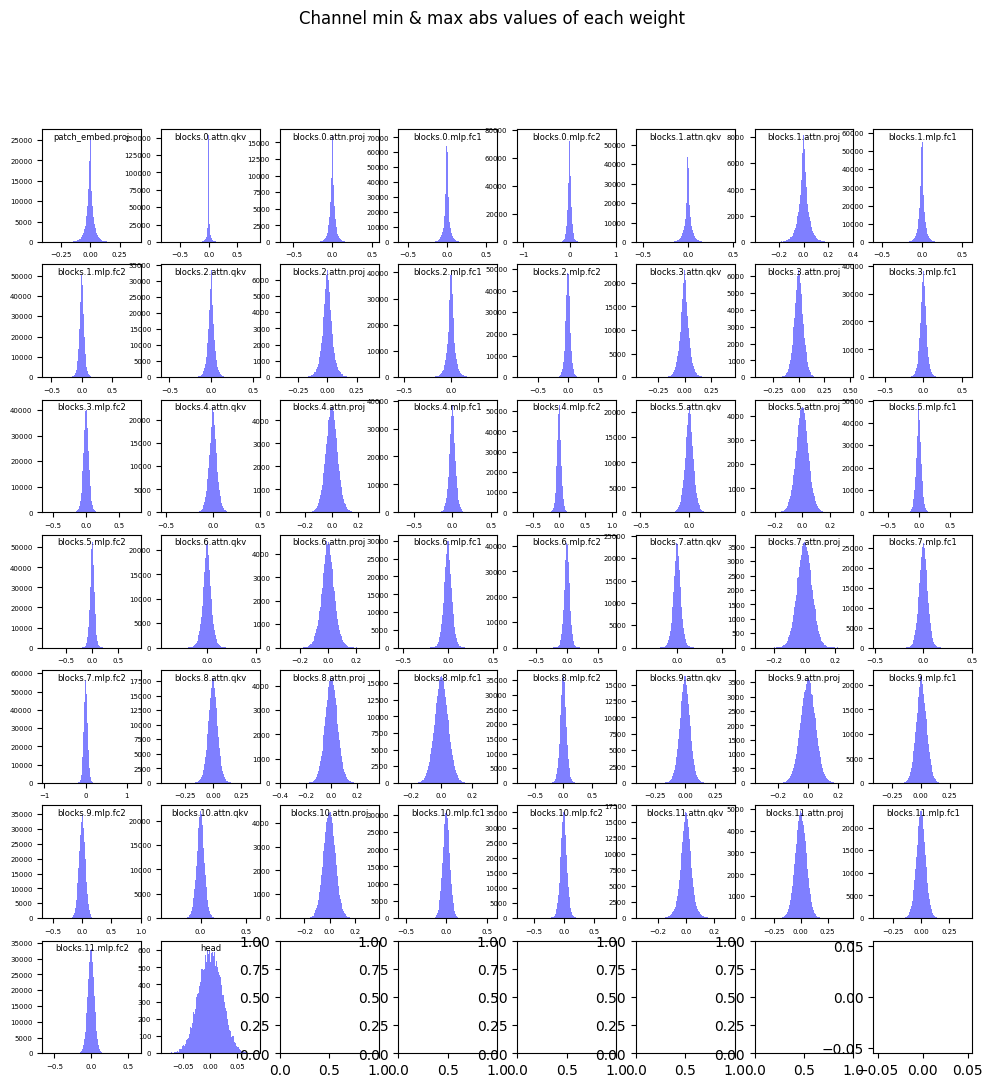

In [113]:
visualize_model_weights(model)

### Activation:

100%|██████████| 781/781 [13:45<00:00,  1.06s/it]


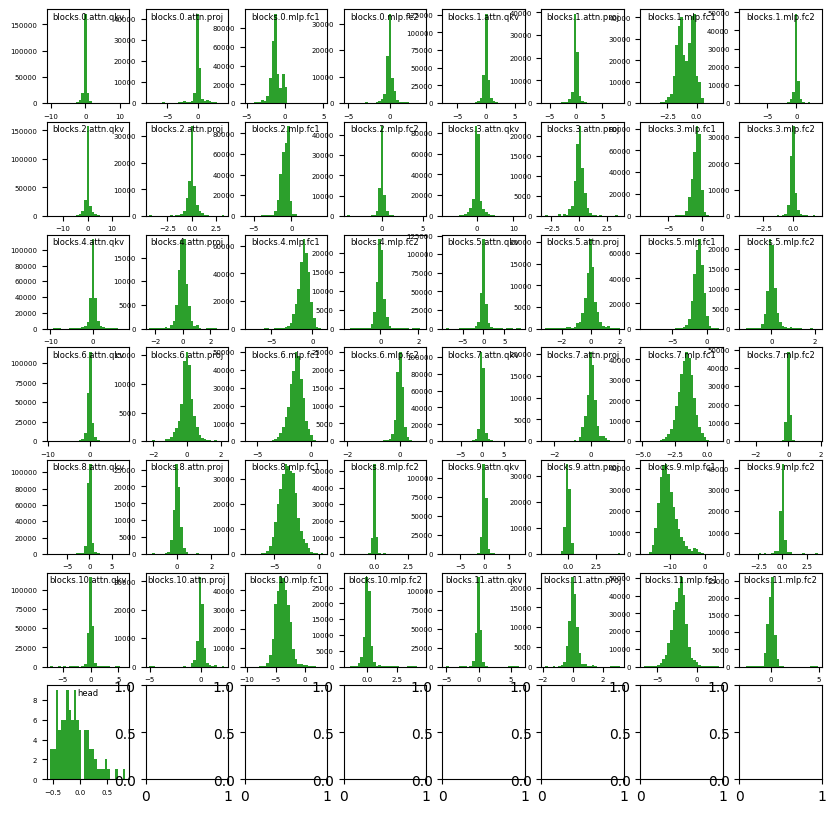

In [46]:
plot_activation_dist(model, train_loader, device="cuda")
model = model.to("cpu")

## Identify the specific layers or components that quantization impacts the most. (10%)

從以下 symmetric quantization & dequantization 誤差分析圖可以看出，在 mlp 中的 fc2 是被 quantization 影響最大的 compoments。

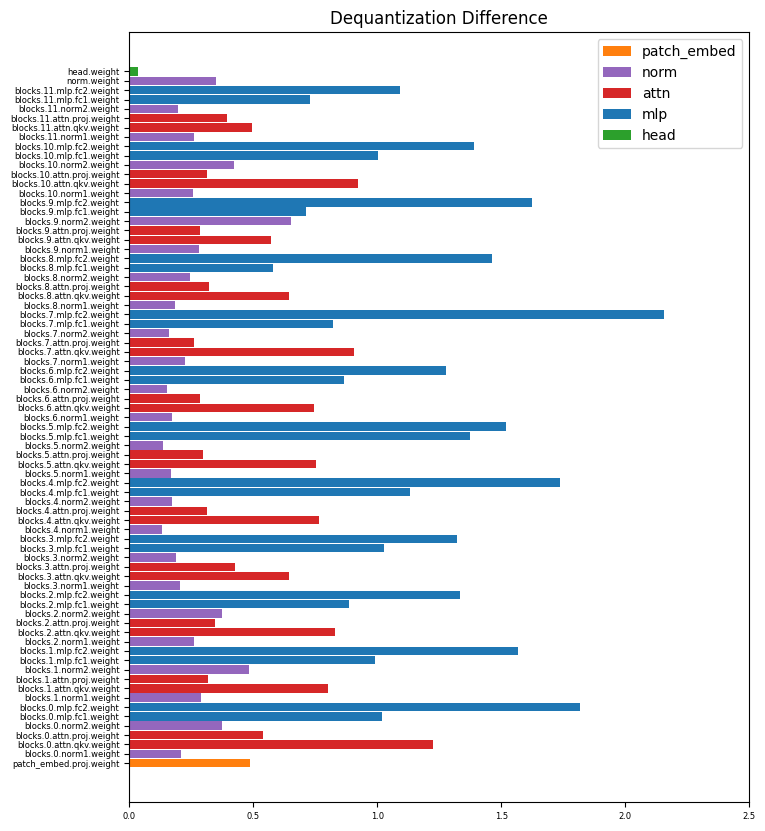

In [101]:
plot_weights_sym_quant_diff(model, model_mode="deit", max_val=2.5)

## Explain why DeiT-S is harder to quantize than MobileNet. Use relevant charts or graphs to support your findings. (10%)

從下圖可看出，MoblieNet 的 weights 在經過 symmetric quantization & dequantization 後的誤差比 DeiT-S 小，因此 MobileNet 會比 DeiT-S 來得容易 quantization。

In [88]:
mobilenet = torch.load("mobilenetv2_0.963.pth", map_location="cpu")

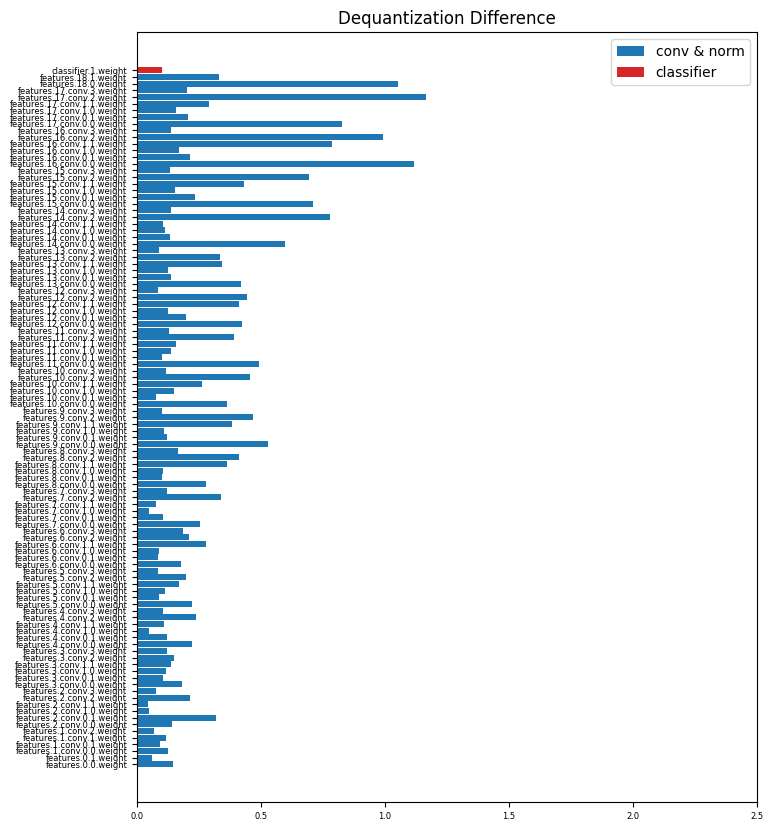

In [89]:
plot_weights_sym_quant_diff(mobilenet, model_mode="mobilenet", max_val=2.5)

## Suggestions for improving quantization on DeiT-S. (5%)

從 quantization 誤差圖來看應該要讓 mlp.fc2 不做 quantization，但是因為 mlp.fc2 參數量很大，mlp.fc2 不做 quantization 會讓 model size 變太大。因此在折衷 model size 與 quantization 誤差後，決定讓參數量較少的 layer normalization 不做 quantization。

## Explain what you have done in your quantization pipeline to enhance model performance.(15%)

1. 將 layer normalization 從 quantization 的目標中剔除。
2. 使用 per-tensor 版本的 SmoothQuant 調整模型權重範圍。
3. 使用 QAT 微調模型，並且 weights 與 activations 採用 FusedMovingAvgObsFakeQuantize 來做最大最小值的統計。
4. 訓練 30 epochs 並以 lr = 1e-4 訓練，在第 5 epoch 時停止更新 weight & activation 的最大最小值，在第 20 epoch 時 lr *= 0.1。
5. 清除 optimizer & scheduler states，再以 lr = 1e-5 繼續訓練 30 epochs。

# Quantizing DeiT-S

## 沒使用 SmoothQuant (per-tensor 版本): Accuracy 最高 91.2%

In [54]:
def prepare_quant_model(model: nn.Module, batch_size: int, ignore_list: list[str] = [], is_qat: bool = True):
    quantizer = PartialXNNPACKQuantizer(ignore_list) if ignore_list else XNNPACKQuantizer()
    quantizer.set_global(get_symmetric_quantization_config(is_qat=is_qat))
    prepared_model = capture_pre_autograd_graph(model, (torch.rand(batch_size, 3, 224, 224),), dynamic_shapes={"x": {0: Dim("batch")}})
    prepared_model = prepare_qat_pt2e(prepared_model, quantizer) if is_qat else prepare_pt2e(prepared_model, quantizer)
    return prepared_model

def train_qat(
    prepared_model: GraphModule,
    lr: float = 1e-4,
    n_epochs: int = 30,
    n_epochs_between_evals: int = 1,
    n_observer_update_epochs: int = 5,
    n_large_lr_epochs: int = 20,
    device: torch.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
) -> None:
    os.makedirs("./model", exist_ok=True)
    os.makedirs("./save", exist_ok=True)
    
    prepared_model.to(device)
    prepared_model.requires_grad_()

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(prepared_model.parameters(), lr)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, [n_large_lr_epochs], 0.1)

    for epoch in range(1, n_epochs + 1):
        print("-" * 50 + f"\nEpoch {epoch}: (lr = {optimizer.param_groups[0]['lr']})")
        assert prepared_model.training, "Model is not training."
        train_one_epoch(prepared_model, criterion, optimizer, train_loader, device)
        if epoch > n_observer_update_epochs:
            print(f"Disabling observer for subseq epochs ... ({epoch=})")
            prepared_model.apply(torch.ao.quantization.disable_observer)
        if epoch % n_epochs_between_evals == 0:
            print(f"Saving and Scoring ... ({epoch=})")
            prepared_model_copy = copy.deepcopy(prepared_model)
            torch.ao.quantization.move_exported_model_to_eval(prepared_model_copy)
            save_file = f"./model/qunatized_DeiT-S_{epoch=}.pth"
            quantized_ep = torch.export.export(convert_pt2e(prepared_model_copy).cpu(), (torch.rand(1, 3, 224, 224),))
            torch.export.save(quantized_ep, save_file)
            torch.save(prepared_model_copy.state_dict(), f"./save/prepared_model__{epoch=}.pth")
            lab4_cifar100_evaluation(save_file)
        
        scheduler.step()

In [56]:
batch_size = 128
ignore_list = ["norm"]

train_loader, test_loader, nb_classes = prepare_data(batch_size)

model: VisionTransformer = torch.load('0.9099_deit3_small_patch16_224.pth', map_location='cpu')

prepared_model = prepare_quant_model(model, batch_size, ignore_list)

Files already downloaded and verified
Files already downloaded and verified
annotating for static quantization


In [57]:
train_qat(prepared_model)

--------------------------------------------------
Epoch 1: (lr = 0.0001)


100%|██████████| 390/390 [02:18<00:00,  2.81it/s]


Saving and Scoring ... (epoch=1)
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 500/500 [00:27<00:00, 17.90it/s]


Accuracy of the model on the test images: 87.4%
Model Size: 21.94 MB
Accuracy: 87.40%
Execution Time: 27.94 s
Model Score: 32.00
--------------------------------------------------
Epoch 2: (lr = 0.0001)


100%|██████████| 390/390 [02:19<00:00,  2.80it/s]


Saving and Scoring ... (epoch=2)
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 500/500 [00:27<00:00, 18.23it/s]


Accuracy of the model on the test images: 89.8%
Model Size: 21.94 MB
Accuracy: 89.80%
Execution Time: 27.43 s
Model Score: 36.00
--------------------------------------------------
Epoch 3: (lr = 0.0001)


100%|██████████| 390/390 [02:19<00:00,  2.80it/s]


Saving and Scoring ... (epoch=3)
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 500/500 [00:27<00:00, 18.09it/s]


Accuracy of the model on the test images: 88.4%
Model Size: 21.94 MB
Accuracy: 88.40%
Execution Time: 27.64 s
Model Score: 34.00
--------------------------------------------------
Epoch 4: (lr = 0.0001)


100%|██████████| 390/390 [02:19<00:00,  2.80it/s]


Saving and Scoring ... (epoch=4)
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 500/500 [00:27<00:00, 18.16it/s]


Accuracy of the model on the test images: 89.0%
Model Size: 21.94 MB
Accuracy: 89.00%
Execution Time: 27.54 s
Model Score: 36.00
--------------------------------------------------
Epoch 5: (lr = 0.0001)


100%|██████████| 390/390 [02:19<00:00,  2.80it/s]


Saving and Scoring ... (epoch=5)
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 500/500 [00:27<00:00, 18.11it/s]


Accuracy of the model on the test images: 90.0%
Model Size: 21.94 MB
Accuracy: 90.00%
Execution Time: 27.62 s
Model Score: 38.00
--------------------------------------------------
Epoch 6: (lr = 0.0001)


100%|██████████| 390/390 [02:19<00:00,  2.81it/s]


Disabling observer for subseq epochs ... (epoch=6)
Saving and Scoring ... (epoch=6)
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 500/500 [00:27<00:00, 18.14it/s]


Accuracy of the model on the test images: 89.2%
Model Size: 21.94 MB
Accuracy: 89.20%
Execution Time: 27.57 s
Model Score: 36.00
--------------------------------------------------
Epoch 7: (lr = 0.0001)


100%|██████████| 390/390 [02:19<00:00,  2.81it/s]


Disabling observer for subseq epochs ... (epoch=7)
Saving and Scoring ... (epoch=7)
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 500/500 [00:27<00:00, 18.11it/s]


Accuracy of the model on the test images: 89.0%
Model Size: 21.94 MB
Accuracy: 89.00%
Execution Time: 27.61 s
Model Score: 36.00
--------------------------------------------------
Epoch 8: (lr = 0.0001)


100%|██████████| 390/390 [02:19<00:00,  2.80it/s]


Disabling observer for subseq epochs ... (epoch=8)
Saving and Scoring ... (epoch=8)
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 500/500 [00:27<00:00, 17.94it/s]


Accuracy of the model on the test images: 88.8%
Model Size: 21.94 MB
Accuracy: 88.80%
Execution Time: 27.87 s
Model Score: 34.00
--------------------------------------------------
Epoch 9: (lr = 0.0001)


100%|██████████| 390/390 [02:19<00:00,  2.80it/s]


Disabling observer for subseq epochs ... (epoch=9)
Saving and Scoring ... (epoch=9)
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 500/500 [00:27<00:00, 18.09it/s]


Accuracy of the model on the test images: 89.0%
Model Size: 21.94 MB
Accuracy: 89.00%
Execution Time: 27.63 s
Model Score: 36.00
--------------------------------------------------
Epoch 10: (lr = 0.0001)


100%|██████████| 390/390 [02:19<00:00,  2.80it/s]


Disabling observer for subseq epochs ... (epoch=10)
Saving and Scoring ... (epoch=10)
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 500/500 [00:27<00:00, 18.10it/s]


Accuracy of the model on the test images: 86.8%
Model Size: 21.94 MB
Accuracy: 86.80%
Execution Time: 27.62 s
Model Score: 30.00
--------------------------------------------------
Epoch 11: (lr = 0.0001)


100%|██████████| 390/390 [02:19<00:00,  2.80it/s]


Disabling observer for subseq epochs ... (epoch=11)
Saving and Scoring ... (epoch=11)
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 500/500 [00:27<00:00, 18.16it/s]


Accuracy of the model on the test images: 89.4%
Model Size: 21.94 MB
Accuracy: 89.40%
Execution Time: 27.53 s
Model Score: 36.00
--------------------------------------------------
Epoch 12: (lr = 0.0001)


100%|██████████| 390/390 [02:18<00:00,  2.81it/s]


Disabling observer for subseq epochs ... (epoch=12)
Saving and Scoring ... (epoch=12)
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 500/500 [00:27<00:00, 17.87it/s]


Accuracy of the model on the test images: 88.8%
Model Size: 21.94 MB
Accuracy: 88.80%
Execution Time: 27.99 s
Model Score: 34.00
--------------------------------------------------
Epoch 13: (lr = 0.0001)


100%|██████████| 390/390 [02:19<00:00,  2.80it/s]


Disabling observer for subseq epochs ... (epoch=13)
Saving and Scoring ... (epoch=13)
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 500/500 [00:27<00:00, 18.07it/s]


Accuracy of the model on the test images: 87.8%
Model Size: 21.94 MB
Accuracy: 87.80%
Execution Time: 27.66 s
Model Score: 32.00
--------------------------------------------------
Epoch 14: (lr = 0.0001)


100%|██████████| 390/390 [02:19<00:00,  2.81it/s]


Disabling observer for subseq epochs ... (epoch=14)
Saving and Scoring ... (epoch=14)
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 500/500 [00:27<00:00, 18.16it/s]


Accuracy of the model on the test images: 89.2%
Model Size: 21.94 MB
Accuracy: 89.20%
Execution Time: 27.54 s
Model Score: 36.00
--------------------------------------------------
Epoch 15: (lr = 0.0001)


100%|██████████| 390/390 [02:19<00:00,  2.80it/s]


Disabling observer for subseq epochs ... (epoch=15)
Saving and Scoring ... (epoch=15)
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 500/500 [00:27<00:00, 17.97it/s]


Accuracy of the model on the test images: 87.4%
Model Size: 21.94 MB
Accuracy: 87.40%
Execution Time: 27.82 s
Model Score: 32.00
--------------------------------------------------
Epoch 16: (lr = 0.0001)


100%|██████████| 390/390 [02:18<00:00,  2.81it/s]


Disabling observer for subseq epochs ... (epoch=16)
Saving and Scoring ... (epoch=16)
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 500/500 [00:27<00:00, 18.15it/s]


Accuracy of the model on the test images: 88.8%
Model Size: 21.94 MB
Accuracy: 88.80%
Execution Time: 27.55 s
Model Score: 34.00
--------------------------------------------------
Epoch 17: (lr = 0.0001)


100%|██████████| 390/390 [02:19<00:00,  2.81it/s]


Disabling observer for subseq epochs ... (epoch=17)
Saving and Scoring ... (epoch=17)
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 500/500 [00:27<00:00, 18.40it/s]


Accuracy of the model on the test images: 89.8%
Model Size: 21.94 MB
Accuracy: 89.80%
Execution Time: 27.18 s
Model Score: 36.00
--------------------------------------------------
Epoch 18: (lr = 0.0001)


100%|██████████| 390/390 [02:18<00:00,  2.81it/s]


Disabling observer for subseq epochs ... (epoch=18)
Saving and Scoring ... (epoch=18)
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 500/500 [00:27<00:00, 17.89it/s]


Accuracy of the model on the test images: 89.0%
Model Size: 21.94 MB
Accuracy: 89.00%
Execution Time: 27.96 s
Model Score: 36.00
--------------------------------------------------
Epoch 19: (lr = 0.0001)


100%|██████████| 390/390 [02:19<00:00,  2.81it/s]


Disabling observer for subseq epochs ... (epoch=19)
Saving and Scoring ... (epoch=19)
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 500/500 [00:27<00:00, 18.00it/s]


Accuracy of the model on the test images: 89.6%
Model Size: 21.94 MB
Accuracy: 89.60%
Execution Time: 27.78 s
Model Score: 36.00
--------------------------------------------------
Epoch 20: (lr = 0.0001)


100%|██████████| 390/390 [02:19<00:00,  2.80it/s]


Disabling observer for subseq epochs ... (epoch=20)
Saving and Scoring ... (epoch=20)
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 500/500 [00:27<00:00, 18.04it/s]


Accuracy of the model on the test images: 88.4%
Model Size: 21.94 MB
Accuracy: 88.40%
Execution Time: 27.72 s
Model Score: 34.00
--------------------------------------------------
Epoch 21: (lr = 1e-05)


100%|██████████| 390/390 [02:18<00:00,  2.81it/s]


Disabling observer for subseq epochs ... (epoch=21)
Saving and Scoring ... (epoch=21)
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 500/500 [00:27<00:00, 18.05it/s]


Accuracy of the model on the test images: 89.8%
Model Size: 21.94 MB
Accuracy: 89.80%
Execution Time: 27.71 s
Model Score: 36.00
--------------------------------------------------
Epoch 22: (lr = 1e-05)


100%|██████████| 390/390 [02:19<00:00,  2.79it/s]


Disabling observer for subseq epochs ... (epoch=22)
Saving and Scoring ... (epoch=22)
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 500/500 [00:27<00:00, 18.09it/s]


Accuracy of the model on the test images: 90.6%
Model Size: 21.94 MB
Accuracy: 90.60%
Execution Time: 27.65 s
Model Score: 38.00
--------------------------------------------------
Epoch 23: (lr = 1e-05)


100%|██████████| 390/390 [02:19<00:00,  2.80it/s]


Disabling observer for subseq epochs ... (epoch=23)
Saving and Scoring ... (epoch=23)
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 500/500 [00:27<00:00, 18.10it/s]


Accuracy of the model on the test images: 90.2%
Model Size: 21.94 MB
Accuracy: 90.20%
Execution Time: 27.62 s
Model Score: 38.00
--------------------------------------------------
Epoch 24: (lr = 1e-05)


100%|██████████| 390/390 [02:19<00:00,  2.81it/s]


Disabling observer for subseq epochs ... (epoch=24)
Saving and Scoring ... (epoch=24)
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 500/500 [00:27<00:00, 17.99it/s]


Accuracy of the model on the test images: 89.6%
Model Size: 21.94 MB
Accuracy: 89.60%
Execution Time: 27.79 s
Model Score: 36.00
--------------------------------------------------
Epoch 25: (lr = 1e-05)


100%|██████████| 390/390 [02:19<00:00,  2.80it/s]


Disabling observer for subseq epochs ... (epoch=25)
Saving and Scoring ... (epoch=25)
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 500/500 [00:27<00:00, 18.10it/s]


Accuracy of the model on the test images: 90.8%
Model Size: 21.94 MB
Accuracy: 90.80%
Execution Time: 27.62 s
Model Score: 38.00
--------------------------------------------------
Epoch 26: (lr = 1e-05)


100%|██████████| 390/390 [02:19<00:00,  2.80it/s]


Disabling observer for subseq epochs ... (epoch=26)
Saving and Scoring ... (epoch=26)
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 500/500 [00:27<00:00, 18.18it/s]


Accuracy of the model on the test images: 90.2%
Model Size: 21.94 MB
Accuracy: 90.20%
Execution Time: 27.51 s
Model Score: 38.00
--------------------------------------------------
Epoch 27: (lr = 1e-05)


100%|██████████| 390/390 [02:19<00:00,  2.80it/s]


Disabling observer for subseq epochs ... (epoch=27)
Saving and Scoring ... (epoch=27)
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 500/500 [00:27<00:00, 18.07it/s]


Accuracy of the model on the test images: 90.8%
Model Size: 21.94 MB
Accuracy: 90.80%
Execution Time: 27.67 s
Model Score: 38.00
--------------------------------------------------
Epoch 28: (lr = 1e-05)


100%|██████████| 390/390 [02:18<00:00,  2.81it/s]


Disabling observer for subseq epochs ... (epoch=28)
Saving and Scoring ... (epoch=28)
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 500/500 [00:27<00:00, 17.95it/s]


Accuracy of the model on the test images: 90.4%
Model Size: 21.94 MB
Accuracy: 90.40%
Execution Time: 27.85 s
Model Score: 38.00
--------------------------------------------------
Epoch 29: (lr = 1e-05)


100%|██████████| 390/390 [02:19<00:00,  2.80it/s]


Disabling observer for subseq epochs ... (epoch=29)
Saving and Scoring ... (epoch=29)
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 500/500 [00:27<00:00, 18.16it/s]


Accuracy of the model on the test images: 90.2%
Model Size: 21.94 MB
Accuracy: 90.20%
Execution Time: 27.53 s
Model Score: 38.00
--------------------------------------------------
Epoch 30: (lr = 1e-05)


100%|██████████| 390/390 [02:19<00:00,  2.80it/s]


Disabling observer for subseq epochs ... (epoch=30)
Saving and Scoring ... (epoch=30)
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 500/500 [00:28<00:00, 17.72it/s]

Accuracy of the model on the test images: 90.0%
Model Size: 21.94 MB
Accuracy: 90.00%
Execution Time: 28.22 s
Model Score: 38.00


In [58]:
train_qat(prepared_model, lr=1e-5)

--------------------------------------------------
Epoch 1: (lr = 1e-05)


100%|██████████| 390/390 [02:18<00:00,  2.81it/s]


Saving and Scoring ... (epoch=1)
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 500/500 [00:27<00:00, 18.17it/s]


Accuracy of the model on the test images: 90.0%
Model Size: 21.94 MB
Accuracy: 90.00%
Execution Time: 27.52 s
Model Score: 38.00
--------------------------------------------------
Epoch 2: (lr = 1e-05)


100%|██████████| 390/390 [02:18<00:00,  2.81it/s]


Saving and Scoring ... (epoch=2)
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 500/500 [00:27<00:00, 18.18it/s]


Accuracy of the model on the test images: 89.6%
Model Size: 21.94 MB
Accuracy: 89.60%
Execution Time: 27.50 s
Model Score: 36.00
--------------------------------------------------
Epoch 3: (lr = 1e-05)


100%|██████████| 390/390 [02:19<00:00,  2.80it/s]


Saving and Scoring ... (epoch=3)
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 500/500 [00:27<00:00, 18.25it/s]


Accuracy of the model on the test images: 90.0%
Model Size: 21.94 MB
Accuracy: 90.00%
Execution Time: 27.40 s
Model Score: 38.00
--------------------------------------------------
Epoch 4: (lr = 1e-05)


100%|██████████| 390/390 [02:19<00:00,  2.80it/s]


Saving and Scoring ... (epoch=4)
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 500/500 [00:27<00:00, 17.99it/s]


Accuracy of the model on the test images: 89.6%
Model Size: 21.94 MB
Accuracy: 89.60%
Execution Time: 27.79 s
Model Score: 36.00
--------------------------------------------------
Epoch 5: (lr = 1e-05)


100%|██████████| 390/390 [02:19<00:00,  2.80it/s]


Saving and Scoring ... (epoch=5)
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 500/500 [00:28<00:00, 17.84it/s]


Accuracy of the model on the test images: 89.8%
Model Size: 21.94 MB
Accuracy: 89.80%
Execution Time: 28.03 s
Model Score: 36.00
--------------------------------------------------
Epoch 6: (lr = 1e-05)


100%|██████████| 390/390 [02:19<00:00,  2.80it/s]


Disabling observer for subseq epochs ... (epoch=6)
Saving and Scoring ... (epoch=6)
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 500/500 [00:27<00:00, 17.98it/s]


Accuracy of the model on the test images: 89.2%
Model Size: 21.94 MB
Accuracy: 89.20%
Execution Time: 27.82 s
Model Score: 36.00
--------------------------------------------------
Epoch 7: (lr = 1e-05)


100%|██████████| 390/390 [02:19<00:00,  2.80it/s]


Disabling observer for subseq epochs ... (epoch=7)
Saving and Scoring ... (epoch=7)
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 500/500 [00:27<00:00, 18.07it/s]


Accuracy of the model on the test images: 90.2%
Model Size: 21.94 MB
Accuracy: 90.20%
Execution Time: 27.67 s
Model Score: 38.00
--------------------------------------------------
Epoch 8: (lr = 1e-05)


100%|██████████| 390/390 [02:19<00:00,  2.80it/s]


Disabling observer for subseq epochs ... (epoch=8)
Saving and Scoring ... (epoch=8)
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 500/500 [00:27<00:00, 18.02it/s]


Accuracy of the model on the test images: 89.6%
Model Size: 21.94 MB
Accuracy: 89.60%
Execution Time: 27.75 s
Model Score: 36.00
--------------------------------------------------
Epoch 9: (lr = 1e-05)


100%|██████████| 390/390 [02:19<00:00,  2.80it/s]


Disabling observer for subseq epochs ... (epoch=9)
Saving and Scoring ... (epoch=9)
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 500/500 [00:27<00:00, 18.18it/s]


Accuracy of the model on the test images: 90.6%
Model Size: 21.94 MB
Accuracy: 90.60%
Execution Time: 27.50 s
Model Score: 38.00
--------------------------------------------------
Epoch 10: (lr = 1e-05)


100%|██████████| 390/390 [02:19<00:00,  2.80it/s]


Disabling observer for subseq epochs ... (epoch=10)
Saving and Scoring ... (epoch=10)
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 500/500 [00:27<00:00, 17.95it/s]


Accuracy of the model on the test images: 90.6%
Model Size: 21.94 MB
Accuracy: 90.60%
Execution Time: 27.85 s
Model Score: 38.00
--------------------------------------------------
Epoch 11: (lr = 1e-05)


100%|██████████| 390/390 [02:19<00:00,  2.80it/s]


Disabling observer for subseq epochs ... (epoch=11)
Saving and Scoring ... (epoch=11)
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 500/500 [00:27<00:00, 18.09it/s]


Accuracy of the model on the test images: 90.6%
Model Size: 21.94 MB
Accuracy: 90.60%
Execution Time: 27.64 s
Model Score: 38.00
--------------------------------------------------
Epoch 12: (lr = 1e-05)


100%|██████████| 390/390 [02:19<00:00,  2.80it/s]


Disabling observer for subseq epochs ... (epoch=12)
Saving and Scoring ... (epoch=12)
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 500/500 [00:27<00:00, 17.92it/s]


Accuracy of the model on the test images: 91.0%
Model Size: 21.94 MB
Accuracy: 91.00%
Execution Time: 27.90 s
Model Score: 40.00
--------------------------------------------------
Epoch 13: (lr = 1e-05)


100%|██████████| 390/390 [02:19<00:00,  2.80it/s]


Disabling observer for subseq epochs ... (epoch=13)
Saving and Scoring ... (epoch=13)
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 500/500 [00:27<00:00, 17.98it/s]


Accuracy of the model on the test images: 90.8%
Model Size: 21.94 MB
Accuracy: 90.80%
Execution Time: 27.82 s
Model Score: 38.00
--------------------------------------------------
Epoch 14: (lr = 1e-05)


100%|██████████| 390/390 [02:19<00:00,  2.80it/s]


Disabling observer for subseq epochs ... (epoch=14)
Saving and Scoring ... (epoch=14)
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 500/500 [00:27<00:00, 18.07it/s]


Accuracy of the model on the test images: 89.4%
Model Size: 21.94 MB
Accuracy: 89.40%
Execution Time: 27.67 s
Model Score: 36.00
--------------------------------------------------
Epoch 15: (lr = 1e-05)


100%|██████████| 390/390 [02:18<00:00,  2.81it/s]


Disabling observer for subseq epochs ... (epoch=15)
Saving and Scoring ... (epoch=15)
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 500/500 [00:27<00:00, 18.00it/s]


Accuracy of the model on the test images: 90.4%
Model Size: 21.94 MB
Accuracy: 90.40%
Execution Time: 27.78 s
Model Score: 38.00
--------------------------------------------------
Epoch 16: (lr = 1e-05)


100%|██████████| 390/390 [02:18<00:00,  2.81it/s]


Disabling observer for subseq epochs ... (epoch=16)
Saving and Scoring ... (epoch=16)
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 500/500 [00:27<00:00, 17.99it/s]


Accuracy of the model on the test images: 89.8%
Model Size: 21.94 MB
Accuracy: 89.80%
Execution Time: 27.79 s
Model Score: 36.00
--------------------------------------------------
Epoch 17: (lr = 1e-05)


100%|██████████| 390/390 [02:18<00:00,  2.81it/s]


Disabling observer for subseq epochs ... (epoch=17)
Saving and Scoring ... (epoch=17)
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 500/500 [00:27<00:00, 18.23it/s]


Accuracy of the model on the test images: 90.4%
Model Size: 21.94 MB
Accuracy: 90.40%
Execution Time: 27.43 s
Model Score: 38.00
--------------------------------------------------
Epoch 18: (lr = 1e-05)


100%|██████████| 390/390 [02:18<00:00,  2.81it/s]


Disabling observer for subseq epochs ... (epoch=18)
Saving and Scoring ... (epoch=18)
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 500/500 [00:27<00:00, 18.21it/s]


Accuracy of the model on the test images: 90.2%
Model Size: 21.94 MB
Accuracy: 90.20%
Execution Time: 27.45 s
Model Score: 38.00
--------------------------------------------------
Epoch 19: (lr = 1e-05)


100%|██████████| 390/390 [02:18<00:00,  2.81it/s]


Disabling observer for subseq epochs ... (epoch=19)
Saving and Scoring ... (epoch=19)
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 500/500 [00:27<00:00, 18.03it/s]


Accuracy of the model on the test images: 91.0%
Model Size: 21.94 MB
Accuracy: 91.00%
Execution Time: 27.73 s
Model Score: 40.00
--------------------------------------------------
Epoch 20: (lr = 1e-05)


100%|██████████| 390/390 [02:19<00:00,  2.81it/s]


Disabling observer for subseq epochs ... (epoch=20)
Saving and Scoring ... (epoch=20)
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 500/500 [00:27<00:00, 18.17it/s]


Accuracy of the model on the test images: 90.2%
Model Size: 21.94 MB
Accuracy: 90.20%
Execution Time: 27.51 s
Model Score: 38.00
--------------------------------------------------
Epoch 21: (lr = 1.0000000000000002e-06)


100%|██████████| 390/390 [02:18<00:00,  2.81it/s]


Disabling observer for subseq epochs ... (epoch=21)
Saving and Scoring ... (epoch=21)
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 500/500 [00:27<00:00, 18.01it/s]


Accuracy of the model on the test images: 90.6%
Model Size: 21.94 MB
Accuracy: 90.60%
Execution Time: 27.77 s
Model Score: 38.00
--------------------------------------------------
Epoch 22: (lr = 1.0000000000000002e-06)


100%|██████████| 390/390 [02:18<00:00,  2.81it/s]


Disabling observer for subseq epochs ... (epoch=22)
Saving and Scoring ... (epoch=22)
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 500/500 [00:27<00:00, 18.20it/s]


Accuracy of the model on the test images: 90.0%
Model Size: 21.94 MB
Accuracy: 90.00%
Execution Time: 27.47 s
Model Score: 38.00
--------------------------------------------------
Epoch 23: (lr = 1.0000000000000002e-06)


100%|██████████| 390/390 [02:18<00:00,  2.81it/s]


Disabling observer for subseq epochs ... (epoch=23)
Saving and Scoring ... (epoch=23)
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 500/500 [00:27<00:00, 18.18it/s]


Accuracy of the model on the test images: 89.4%
Model Size: 21.94 MB
Accuracy: 89.40%
Execution Time: 27.50 s
Model Score: 36.00
--------------------------------------------------
Epoch 24: (lr = 1.0000000000000002e-06)


100%|██████████| 390/390 [02:18<00:00,  2.81it/s]


Disabling observer for subseq epochs ... (epoch=24)
Saving and Scoring ... (epoch=24)
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 500/500 [00:27<00:00, 18.28it/s]


Accuracy of the model on the test images: 90.0%
Model Size: 21.94 MB
Accuracy: 90.00%
Execution Time: 27.36 s
Model Score: 38.00
--------------------------------------------------
Epoch 25: (lr = 1.0000000000000002e-06)


100%|██████████| 390/390 [02:18<00:00,  2.81it/s]


Disabling observer for subseq epochs ... (epoch=25)
Saving and Scoring ... (epoch=25)
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 500/500 [00:27<00:00, 18.27it/s]


Accuracy of the model on the test images: 90.2%
Model Size: 21.94 MB
Accuracy: 90.20%
Execution Time: 27.37 s
Model Score: 38.00
--------------------------------------------------
Epoch 26: (lr = 1.0000000000000002e-06)


100%|██████████| 390/390 [02:18<00:00,  2.81it/s]


Disabling observer for subseq epochs ... (epoch=26)
Saving and Scoring ... (epoch=26)
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 500/500 [00:27<00:00, 18.16it/s]


Accuracy of the model on the test images: 90.4%
Model Size: 21.94 MB
Accuracy: 90.40%
Execution Time: 27.54 s
Model Score: 38.00
--------------------------------------------------
Epoch 27: (lr = 1.0000000000000002e-06)


100%|██████████| 390/390 [02:18<00:00,  2.81it/s]


Disabling observer for subseq epochs ... (epoch=27)
Saving and Scoring ... (epoch=27)
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 500/500 [00:27<00:00, 18.28it/s]


Accuracy of the model on the test images: 90.6%
Model Size: 21.94 MB
Accuracy: 90.60%
Execution Time: 27.35 s
Model Score: 38.00
--------------------------------------------------
Epoch 28: (lr = 1.0000000000000002e-06)


100%|██████████| 390/390 [02:18<00:00,  2.81it/s]


Disabling observer for subseq epochs ... (epoch=28)
Saving and Scoring ... (epoch=28)
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 500/500 [00:27<00:00, 17.98it/s]


Accuracy of the model on the test images: 91.2%
Model Size: 21.94 MB
Accuracy: 91.20%
Execution Time: 27.80 s
Model Score: 40.00
--------------------------------------------------
Epoch 29: (lr = 1.0000000000000002e-06)


100%|██████████| 390/390 [02:18<00:00,  2.81it/s]


Disabling observer for subseq epochs ... (epoch=29)
Saving and Scoring ... (epoch=29)
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 500/500 [00:27<00:00, 18.15it/s]


Accuracy of the model on the test images: 90.4%
Model Size: 21.94 MB
Accuracy: 90.40%
Execution Time: 27.54 s
Model Score: 38.00
--------------------------------------------------
Epoch 30: (lr = 1.0000000000000002e-06)


100%|██████████| 390/390 [02:18<00:00,  2.81it/s]


Disabling observer for subseq epochs ... (epoch=30)
Saving and Scoring ... (epoch=30)
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 500/500 [00:27<00:00, 17.91it/s]

Accuracy of the model on the test images: 90.0%
Model Size: 21.94 MB
Accuracy: 90.00%
Execution Time: 27.93 s
Model Score: 38.00


## 有使用 SmoothQuant (per-tensor 版本): Accuracy 最高 92.4%

In [43]:
from typing import Any, Callable
from torch.fx import Node, GraphModule
from torch.ao.quantization import FakeQuantize


def smooth_quant(prepared_model: GraphModule, alpha: float = 0.5, is_print_info: bool = False) -> None:
    ########################################## [Helper Functions] ######################################################
    def assert_check_node_linear(node: Node) -> None:
        assert node.op == "call_function" and node.target == torch.ops.aten.linear.default
    def assert_check_node_layernorm(node: Node) -> None:
        assert node.op == "call_function" and node.target == torch.ops.aten.layer_norm.default
    def assert_check_node_observer(node: Node) -> None:
        assert node.op == "call_module" and "activation_post_process" in node.target
    def assert_check_node_get_attr(node: Node) -> None:
        assert node.op == "get_attr"
    def assert_is_tensor(x: Any) -> None:
        assert isinstance(x, torch.Tensor), f"Got [type(x)] == {type(x)}."

    def is_pass_assert(assert_op: Callable[[Node], None], node: Node) -> bool:
        try:
            assert_op(node)
        except AssertionError:
            return False
        return True

    def print_node(node: Node, is_all_info: bool = False, end="\n") -> Node:
        if is_all_info:
            print(f"<Node[{node.name}] op={node.op}, target={node.target}, args={node.args}, kwargs={node.kwargs}>", end=end)
        else:
            print(f"<Node[{node.name}] op={node.op}, target={node.target}>", end=end)

    def calc_migrate_scale(act_abs_max: float, wet_abs_max: float, alpha: float) -> tuple[float, float]:
        migrate_scale = (act_abs_max ** alpha) / (wet_abs_max ** (1 - alpha))
        return migrate_scale, 1. / migrate_scale

    def get_tensor(tensor_node: Node, model: GraphModule) -> torch.Tensor:
        try:
            return getattr(model, tensor_node.target)
        except Exception as e:
            print_node(tensor_node, True)
            raise e

    def get_observer_module(observer_node: Node, model: GraphModule) -> FakeQuantize:
        try:
            return getattr(model, observer_node.target)
        except Exception as e:
            print_node(observer_node, True)
            raise e

    def get_layernorm_scale_shift(node: Node, model: GraphModule) -> tuple[torch.Tensor, torch.Tensor]:
        scale_node, shift_node = node.args[2], node.args[3]
        assert_check_node_get_attr(scale_node)
        assert_check_node_get_attr(shift_node)
        return get_tensor(scale_node, model), get_tensor(shift_node, model)

    def get_linear_weight_stat(node: Node, model: GraphModule) -> tuple[float, FakeQuantize, torch.Tensor]:
        assert_check_node_linear(node)
        observer_node = node.args[1]
        assert_check_node_observer(observer_node)
        weight_node = observer_node.args[0]
        assert_check_node_get_attr(weight_node)
        weight = getattr(model, weight_node.target)
        assert_is_tensor(weight)
        return weight.abs().max().item(), get_observer_module(observer_node, model), weight

    def get_linear_bias_stat(node: Node, model: GraphModule) -> tuple[float, FakeQuantize | None, torch.Tensor | None]:
        assert_check_node_linear(node)
        bias_node = node.args[2] if len(node.args) >= 3 else None
        if not bias_node:
            return None, None, None
        if is_pass_assert(assert_check_node_observer, bias_node):
            bias_observer = get_observer_module(bias_node, model)
            bias_node = bias_node.args[0]
        else:
            bias_observer = None
        assert_check_node_get_attr(bias_node)
        bias = get_tensor(bias_node, model)
        return bias.abs().max().item(), bias_observer, bias

    def get_activation_stat(node: Node, model: GraphModule) -> tuple[float, FakeQuantize]:
        assert_check_node_observer(node)
        observer = get_observer_module(node, model)
        min_val = observer.activation_post_process.min_val.item()
        max_val = observer.activation_post_process.max_val.item()
        return max(abs(min_val), abs(max_val)), observer

    def get_weight_activation_stats(node: Node, model: GraphModule) -> tuple[tuple[float, FakeQuantize, torch.Tensor], tuple[float, FakeQuantize]]:
        input_act_observer_node = node.args[0]
        return get_linear_weight_stat(node, model), get_activation_stat(input_act_observer_node, model)

    def update_tensor_observer(scale: float, tensor: torch.Tensor | None = None, observer: FakeQuantize | None = None) -> None:
        if tensor is not None:
            tensor.data *= scale
        if observer is not None:
            observer.scale.data *= scale
            observer.activation_post_process.min_val.data *= scale
            observer.activation_post_process.max_val.data *= scale

    def update_observer_min_max_by_tensor(observer: FakeQuantize, tensor: torch.Tensor) -> None:
        observer.activation_post_process.min_val.data = tensor.min()
        observer.activation_post_process.max_val.data = tensor.max()

    def update_qkv_param_observer(scale: float, weight: torch.Tensor, bias: torch.Tensor | None = None, wet_observer: FakeQuantize | None = None, bias_observer: FakeQuantize | None = None) -> None:
        assert weight.size(0) % 3 == 0
        v_channels = weight.size(0) // 3
        weight.data[-v_channels:] *= scale
        if bias is not None:
            bias.data[-v_channels:] *= scale
        if wet_observer is not None:
            wet_observer.scale.data *= scale
            update_observer_min_max_by_tensor(wet_observer, weight)
        if bias_observer is not None:
            bias_observer.scale.data *= scale
            update_observer_min_max_by_tensor(bias_observer, bias)

    def trace_to_prev_node(node: Node, check_assert_op: Callable[[Node], None]) -> Node:
        _node = node
        while not is_pass_assert(check_assert_op, _node):
            _node = _node.args[0]
        return _node

    ########################################## [Dispatch Functions] ######################################################
    def get_linear_type(node: Node) -> str:
        assert_check_node_linear(node)
        parent = node.args[1]
        if parent.op != "get_attr":
            parent = parent.args[0]

        assert parent.op == "get_attr"
        param_name = parent.target
        if "attn_qkv"  in param_name: return "attn_qkv"
        if "attn_proj" in param_name: return "attn_proj"
        if "mlp_fc1"   in param_name: return "mlp_fc1"
        if "mlp_fc2"   in param_name: return "mlp_fc2"
        if "head"      in param_name: return "head"
        return "other"

    def smooth_attn_qkv_linear(node: Node, model: GraphModule, alpha: float = 0.5) -> None:
        (wet_abs_max, wet_observer, weight), (act_abs_max, act_observer) = get_weight_activation_stats(node, model)
        observer_node = node.args[0]
        layernorm_node = observer_node.args[0]
        assert_check_node_layernorm(layernorm_node)
        layernorm_scale, layernorm_shift = get_layernorm_scale_shift(layernorm_node, model)

        migrate_scale, recip_migrate_scale = calc_migrate_scale(act_abs_max, wet_abs_max, alpha)
        update_tensor_observer(migrate_scale, weight, wet_observer)
        update_tensor_observer(recip_migrate_scale, None, act_observer)
        update_tensor_observer(recip_migrate_scale, layernorm_scale, None)
        update_tensor_observer(recip_migrate_scale, layernorm_shift, None)

    def smooth_attn_proj_linear(node: Node, model: GraphModule, alpha: float = 0.5) -> None:
        (wet_abs_max, wet_observer, weight), (act_abs_max, act_observer) = get_weight_activation_stats(node, model)
        observer_node = node.args[0]
        qkv_observer_node = trace_to_prev_node(observer_node.args[0], assert_check_node_observer)
        qkv_linear_node = qkv_observer_node.args[0]

        qkv_act_observer = get_observer_module(qkv_observer_node, model)
        _, qkv_wet_observer, qkv_weight = get_linear_weight_stat(qkv_linear_node, model)
        _, qkv_bias_observer, qkv_bias = get_linear_bias_stat(qkv_linear_node, model)

        migrate_scale, recip_migrate_scale = calc_migrate_scale(act_abs_max, wet_abs_max, alpha)
        update_tensor_observer(migrate_scale, weight, wet_observer)
        update_tensor_observer(recip_migrate_scale, None, act_observer)
        update_tensor_observer(recip_migrate_scale, None, qkv_act_observer)
        update_qkv_param_observer(recip_migrate_scale, qkv_weight, qkv_bias, qkv_wet_observer, qkv_bias_observer)

    def smooth_mlp_fc1_linear(node: Node, model: GraphModule, alpha: float = 0.5) -> None:
        (wet_abs_max, wet_observer, weight), (act_abs_max, act_observer) = get_weight_activation_stats(node, model)
        observer_node = node.args[0]
        layernorm_node = observer_node.args[0]
        
        assert_check_node_layernorm(layernorm_node)
        layernorm_scale, layernorm_shift = get_layernorm_scale_shift(layernorm_node, model)

        migrate_scale, recip_migrate_scale = calc_migrate_scale(act_abs_max, wet_abs_max, alpha)
        update_tensor_observer(migrate_scale, weight, wet_observer)
        update_tensor_observer(recip_migrate_scale, None, act_observer)
        update_tensor_observer(recip_migrate_scale, layernorm_scale, None)
        update_tensor_observer(recip_migrate_scale, layernorm_shift, None)

    def smooth_mlp_fc2_linear(node: Node, model: GraphModule, alpha: float = 0.5) -> None:
        (wet_abs_max, wet_observer, weight), (act_abs_max, act_observer) = get_weight_activation_stats(node, model)
        observer_node = node.args[0]
        pre_observer_node = trace_to_prev_node(observer_node.args[0], assert_check_node_observer)
        pre_linear_node = pre_observer_node.args[0]

        pre_act_observer = get_observer_module(pre_observer_node, model)
        _, pre_wet_observer, pre_weight = get_linear_weight_stat(pre_linear_node, model)
        _, pre_bias_observer, pre_bias = get_linear_bias_stat(pre_linear_node, model)

        migrate_scale, recip_migrate_scale = calc_migrate_scale(act_abs_max, wet_abs_max, alpha)
        update_tensor_observer(migrate_scale, weight, wet_observer)
        update_tensor_observer(recip_migrate_scale, None, act_observer)
        update_tensor_observer(recip_migrate_scale, pre_weight, pre_wet_observer)
        update_tensor_observer(recip_migrate_scale, pre_bias, pre_bias_observer)
        update_tensor_observer(recip_migrate_scale, None, pre_act_observer)

    def smooth_head_linear(node: Node, model: GraphModule, alpha: float = 0.5) -> None:
        (wet_abs_max, wet_observer, weight), (act_abs_max, act_observer) = get_weight_activation_stats(node, model)
        layernorm_node = trace_to_prev_node(node, assert_check_node_layernorm)

        assert_check_node_layernorm(layernorm_node)
        layernorm_scale, layernorm_shift = get_layernorm_scale_shift(layernorm_node, model)

        migrate_scale, recip_migrate_scale = calc_migrate_scale(act_abs_max, wet_abs_max, alpha)
        update_tensor_observer(migrate_scale, weight, wet_observer)
        update_tensor_observer(recip_migrate_scale, None, act_observer)
        update_tensor_observer(recip_migrate_scale, layernorm_scale, None)
        update_tensor_observer(recip_migrate_scale, layernorm_shift, None)
    
    ########################################## [SmoothQuant] ######################################################
    for node in prepared_model.graph.nodes:
        if node.op != "call_function":
            continue
        if node.target != torch.ops.aten.linear.default:
            continue
        
        if is_print_info:
            print("-" * 50)
            print_node(node)

        linear_type = get_linear_type(node)
        if linear_type == "attn_qkv":
            smooth_attn_qkv_linear(node, prepared_model, alpha)
        elif linear_type == "attn_proj":
            smooth_attn_proj_linear(node, prepared_model, alpha)
        elif linear_type == "mlp_fc1":
            smooth_mlp_fc1_linear(node, prepared_model, alpha)
        elif linear_type == "mlp_fc2":
            smooth_mlp_fc2_linear(node, prepared_model, alpha)
        elif linear_type == "head":
            smooth_head_linear(node, prepared_model, alpha)
        else:
            raise ValueError(f"Invalid linear type: [{linear_type}]")
    
    prepared_model.recompile()


In [69]:
def prepare_deits_model_dataset(
    is_qat = False,
    batch_size = 128,
    ignore_list = ["norm"]
):
    train_loader, test_loader, _ = prepare_data(batch_size)
    model: VisionTransformer = torch.load('0.9099_deit3_small_patch16_224.pth', map_location='cpu')
    prepared_model = prepare_quant_model(model, batch_size, ignore_list, is_qat).cpu()
    return (model, prepared_model), (train_loader, test_loader)

def convert_export_save_program(prepared_model: GraphModule, filename: str) -> tuple[GraphModule, ExportedProgram]:
    prepared_model = copy.deepcopy(prepared_model)
    torch.ao.quantization.move_exported_model_to_eval(prepared_model)
    converted_model = convert_pt2e(prepared_model)
    exported_program = torch.export.export(converted_model, (torch.rand(1, 3, 224, 224),))
    torch.export.save(exported_program, filename)
    return converted_model, exported_program

In [72]:
(model, prepared_model), (train_loader, test_loader) = prepare_deits_model_dataset(is_qat=True)
calibrate(prepared_model, train_loader)
smooth_quant(prepared_model)

Files already downloaded and verified
Files already downloaded and verified
annotating for static quantization


In [73]:
train_qat(prepared_model)

--------------------------------------------------
Epoch 1: (lr = 0.0001)


  0%|          | 0/390 [00:00<?, ?it/s]/home/pairlab/anaconda3/envs/EdgeAI/lib/python3.11/site-packages/torch/ao/quantization/fake_quantize.py:353: UserWarning: _aminmax is deprecated as of PyTorch 1.11 and will be removed in a future release. Use aminmax instead. This warning will only appear once per process. (Triggered internally at ../aten/src/ATen/native/ReduceAllOps.cpp:71.)
  return torch.fused_moving_avg_obs_fake_quant(
100%|██████████| 390/390 [02:19<00:00,  2.80it/s]


Saving and Scoring ... (epoch=1)
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 500/500 [00:27<00:00, 18.45it/s]


Accuracy of the model on the test images: 77.0%
Model Size: 21.94 MB
Accuracy: 77.00%
Execution Time: 27.10 s
Model Score: 20.00
--------------------------------------------------
Epoch 2: (lr = 0.0001)


100%|██████████| 390/390 [02:18<00:00,  2.81it/s]


Saving and Scoring ... (epoch=2)
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 500/500 [00:27<00:00, 18.36it/s]


Accuracy of the model on the test images: 82.8%
Model Size: 21.94 MB
Accuracy: 82.80%
Execution Time: 27.23 s
Model Score: 20.00
--------------------------------------------------
Epoch 3: (lr = 0.0001)


100%|██████████| 390/390 [02:18<00:00,  2.82it/s]


Saving and Scoring ... (epoch=3)
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 500/500 [00:27<00:00, 18.51it/s]


Accuracy of the model on the test images: 85.0%
Model Size: 21.94 MB
Accuracy: 85.00%
Execution Time: 27.02 s
Model Score: 20.00
--------------------------------------------------
Epoch 4: (lr = 0.0001)


100%|██████████| 390/390 [02:18<00:00,  2.81it/s]


Saving and Scoring ... (epoch=4)
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 500/500 [00:27<00:00, 18.31it/s]


Accuracy of the model on the test images: 86.6%
Model Size: 21.94 MB
Accuracy: 86.60%
Execution Time: 27.30 s
Model Score: 30.00
--------------------------------------------------
Epoch 5: (lr = 0.0001)


100%|██████████| 390/390 [02:18<00:00,  2.81it/s]


Saving and Scoring ... (epoch=5)
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 500/500 [00:27<00:00, 18.41it/s]


Accuracy of the model on the test images: 86.6%
Model Size: 21.94 MB
Accuracy: 86.60%
Execution Time: 27.16 s
Model Score: 30.00
--------------------------------------------------
Epoch 6: (lr = 0.0001)


100%|██████████| 390/390 [02:18<00:00,  2.81it/s]


Disabling observer for subseq epochs ... (epoch=6)
Saving and Scoring ... (epoch=6)
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 500/500 [00:27<00:00, 18.25it/s]


Accuracy of the model on the test images: 87.2%
Model Size: 21.94 MB
Accuracy: 87.20%
Execution Time: 27.40 s
Model Score: 32.00
--------------------------------------------------
Epoch 7: (lr = 0.0001)


100%|██████████| 390/390 [02:18<00:00,  2.81it/s]


Disabling observer for subseq epochs ... (epoch=7)
Saving and Scoring ... (epoch=7)
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 500/500 [00:27<00:00, 18.11it/s]


Accuracy of the model on the test images: 86.2%
Model Size: 21.94 MB
Accuracy: 86.20%
Execution Time: 27.61 s
Model Score: 30.00
--------------------------------------------------
Epoch 8: (lr = 0.0001)


100%|██████████| 390/390 [02:18<00:00,  2.81it/s]


Disabling observer for subseq epochs ... (epoch=8)
Saving and Scoring ... (epoch=8)
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 500/500 [00:27<00:00, 18.28it/s]


Accuracy of the model on the test images: 88.2%
Model Size: 21.94 MB
Accuracy: 88.20%
Execution Time: 27.36 s
Model Score: 34.00
--------------------------------------------------
Epoch 9: (lr = 0.0001)


100%|██████████| 390/390 [02:18<00:00,  2.81it/s]


Disabling observer for subseq epochs ... (epoch=9)
Saving and Scoring ... (epoch=9)
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 500/500 [00:27<00:00, 18.19it/s]


Accuracy of the model on the test images: 88.2%
Model Size: 21.94 MB
Accuracy: 88.20%
Execution Time: 27.49 s
Model Score: 34.00
--------------------------------------------------
Epoch 10: (lr = 0.0001)


100%|██████████| 390/390 [02:18<00:00,  2.81it/s]


Disabling observer for subseq epochs ... (epoch=10)
Saving and Scoring ... (epoch=10)
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 500/500 [00:27<00:00, 18.22it/s]


Accuracy of the model on the test images: 86.4%
Model Size: 21.94 MB
Accuracy: 86.40%
Execution Time: 27.44 s
Model Score: 30.00
--------------------------------------------------
Epoch 11: (lr = 0.0001)


100%|██████████| 390/390 [02:18<00:00,  2.81it/s]


Disabling observer for subseq epochs ... (epoch=11)
Saving and Scoring ... (epoch=11)
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 500/500 [00:27<00:00, 18.10it/s]


Accuracy of the model on the test images: 87.8%
Model Size: 21.94 MB
Accuracy: 87.80%
Execution Time: 27.63 s
Model Score: 32.00
--------------------------------------------------
Epoch 12: (lr = 0.0001)


100%|██████████| 390/390 [02:18<00:00,  2.81it/s]


Disabling observer for subseq epochs ... (epoch=12)
Saving and Scoring ... (epoch=12)
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 500/500 [00:27<00:00, 17.96it/s]


Accuracy of the model on the test images: 88.8%
Model Size: 21.94 MB
Accuracy: 88.80%
Execution Time: 27.84 s
Model Score: 34.00
--------------------------------------------------
Epoch 13: (lr = 0.0001)


100%|██████████| 390/390 [02:18<00:00,  2.81it/s]


Disabling observer for subseq epochs ... (epoch=13)
Saving and Scoring ... (epoch=13)
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 500/500 [00:27<00:00, 17.89it/s]


Accuracy of the model on the test images: 89.2%
Model Size: 21.94 MB
Accuracy: 89.20%
Execution Time: 27.96 s
Model Score: 36.00
--------------------------------------------------
Epoch 14: (lr = 0.0001)


100%|██████████| 390/390 [02:18<00:00,  2.81it/s]


Disabling observer for subseq epochs ... (epoch=14)
Saving and Scoring ... (epoch=14)
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 500/500 [00:27<00:00, 18.24it/s]


Accuracy of the model on the test images: 87.6%
Model Size: 21.94 MB
Accuracy: 87.60%
Execution Time: 27.41 s
Model Score: 32.00
--------------------------------------------------
Epoch 15: (lr = 0.0001)


100%|██████████| 390/390 [02:18<00:00,  2.81it/s]


Disabling observer for subseq epochs ... (epoch=15)
Saving and Scoring ... (epoch=15)
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 500/500 [00:27<00:00, 18.09it/s]


Accuracy of the model on the test images: 87.2%
Model Size: 21.94 MB
Accuracy: 87.20%
Execution Time: 27.64 s
Model Score: 32.00
--------------------------------------------------
Epoch 16: (lr = 0.0001)


100%|██████████| 390/390 [02:18<00:00,  2.81it/s]


Disabling observer for subseq epochs ... (epoch=16)
Saving and Scoring ... (epoch=16)
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 500/500 [00:27<00:00, 18.07it/s]


Accuracy of the model on the test images: 87.6%
Model Size: 21.94 MB
Accuracy: 87.60%
Execution Time: 27.67 s
Model Score: 32.00
--------------------------------------------------
Epoch 17: (lr = 0.0001)


100%|██████████| 390/390 [02:18<00:00,  2.81it/s]


Disabling observer for subseq epochs ... (epoch=17)
Saving and Scoring ... (epoch=17)
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 500/500 [00:27<00:00, 18.26it/s]


Accuracy of the model on the test images: 88.8%
Model Size: 21.94 MB
Accuracy: 88.80%
Execution Time: 27.38 s
Model Score: 34.00
--------------------------------------------------
Epoch 18: (lr = 0.0001)


100%|██████████| 390/390 [02:18<00:00,  2.81it/s]


Disabling observer for subseq epochs ... (epoch=18)
Saving and Scoring ... (epoch=18)
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 500/500 [00:27<00:00, 18.29it/s]


Accuracy of the model on the test images: 88.8%
Model Size: 21.94 MB
Accuracy: 88.80%
Execution Time: 27.33 s
Model Score: 34.00
--------------------------------------------------
Epoch 19: (lr = 0.0001)


100%|██████████| 390/390 [02:18<00:00,  2.81it/s]


Disabling observer for subseq epochs ... (epoch=19)
Saving and Scoring ... (epoch=19)
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 500/500 [00:27<00:00, 18.11it/s]


Accuracy of the model on the test images: 89.4%
Model Size: 21.94 MB
Accuracy: 89.40%
Execution Time: 27.62 s
Model Score: 36.00
--------------------------------------------------
Epoch 20: (lr = 0.0001)


100%|██████████| 390/390 [02:18<00:00,  2.81it/s]


Disabling observer for subseq epochs ... (epoch=20)
Saving and Scoring ... (epoch=20)
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 500/500 [00:27<00:00, 18.07it/s]


Accuracy of the model on the test images: 88.4%
Model Size: 21.94 MB
Accuracy: 88.40%
Execution Time: 27.67 s
Model Score: 34.00
--------------------------------------------------
Epoch 21: (lr = 1e-05)


100%|██████████| 390/390 [02:18<00:00,  2.81it/s]


Disabling observer for subseq epochs ... (epoch=21)
Saving and Scoring ... (epoch=21)
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 500/500 [00:27<00:00, 18.30it/s]


Accuracy of the model on the test images: 89.2%
Model Size: 21.94 MB
Accuracy: 89.20%
Execution Time: 27.32 s
Model Score: 36.00
--------------------------------------------------
Epoch 22: (lr = 1e-05)


100%|██████████| 390/390 [02:18<00:00,  2.81it/s]


Disabling observer for subseq epochs ... (epoch=22)
Saving and Scoring ... (epoch=22)
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 500/500 [00:27<00:00, 18.17it/s]


Accuracy of the model on the test images: 90.6%
Model Size: 21.94 MB
Accuracy: 90.60%
Execution Time: 27.52 s
Model Score: 38.00
--------------------------------------------------
Epoch 23: (lr = 1e-05)


100%|██████████| 390/390 [02:18<00:00,  2.81it/s]


Disabling observer for subseq epochs ... (epoch=23)
Saving and Scoring ... (epoch=23)
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 500/500 [00:27<00:00, 18.31it/s]


Accuracy of the model on the test images: 90.2%
Model Size: 21.94 MB
Accuracy: 90.20%
Execution Time: 27.30 s
Model Score: 38.00
--------------------------------------------------
Epoch 24: (lr = 1e-05)


100%|██████████| 390/390 [02:18<00:00,  2.81it/s]


Disabling observer for subseq epochs ... (epoch=24)
Saving and Scoring ... (epoch=24)
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 500/500 [00:27<00:00, 18.43it/s]


Accuracy of the model on the test images: 90.4%
Model Size: 21.94 MB
Accuracy: 90.40%
Execution Time: 27.13 s
Model Score: 38.00
--------------------------------------------------
Epoch 25: (lr = 1e-05)


100%|██████████| 390/390 [02:18<00:00,  2.81it/s]


Disabling observer for subseq epochs ... (epoch=25)
Saving and Scoring ... (epoch=25)
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 500/500 [00:27<00:00, 18.35it/s]


Accuracy of the model on the test images: 90.4%
Model Size: 21.94 MB
Accuracy: 90.40%
Execution Time: 27.26 s
Model Score: 38.00
--------------------------------------------------
Epoch 26: (lr = 1e-05)


100%|██████████| 390/390 [02:18<00:00,  2.81it/s]


Disabling observer for subseq epochs ... (epoch=26)
Saving and Scoring ... (epoch=26)
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 500/500 [00:27<00:00, 18.08it/s]


Accuracy of the model on the test images: 90.2%
Model Size: 21.94 MB
Accuracy: 90.20%
Execution Time: 27.66 s
Model Score: 38.00
--------------------------------------------------
Epoch 27: (lr = 1e-05)


100%|██████████| 390/390 [02:18<00:00,  2.81it/s]


Disabling observer for subseq epochs ... (epoch=27)
Saving and Scoring ... (epoch=27)
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 500/500 [00:27<00:00, 18.22it/s]


Accuracy of the model on the test images: 91.8%
Model Size: 21.94 MB
Accuracy: 91.80%
Execution Time: 27.44 s
Model Score: 40.00
--------------------------------------------------
Epoch 28: (lr = 1e-05)


100%|██████████| 390/390 [02:18<00:00,  2.81it/s]


Disabling observer for subseq epochs ... (epoch=28)
Saving and Scoring ... (epoch=28)
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 500/500 [00:26<00:00, 18.52it/s]


Accuracy of the model on the test images: 90.8%
Model Size: 21.94 MB
Accuracy: 90.80%
Execution Time: 27.00 s
Model Score: 38.00
--------------------------------------------------
Epoch 29: (lr = 1e-05)


100%|██████████| 390/390 [02:18<00:00,  2.81it/s]


Disabling observer for subseq epochs ... (epoch=29)
Saving and Scoring ... (epoch=29)
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 500/500 [00:27<00:00, 18.29it/s]


Accuracy of the model on the test images: 90.8%
Model Size: 21.94 MB
Accuracy: 90.80%
Execution Time: 27.34 s
Model Score: 38.00
--------------------------------------------------
Epoch 30: (lr = 1e-05)


100%|██████████| 390/390 [02:18<00:00,  2.81it/s]


Disabling observer for subseq epochs ... (epoch=30)
Saving and Scoring ... (epoch=30)
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 500/500 [00:27<00:00, 17.99it/s]

Accuracy of the model on the test images: 90.4%
Model Size: 21.94 MB
Accuracy: 90.40%
Execution Time: 27.80 s
Model Score: 38.00


In [74]:
train_qat(prepared_model, 1e-5)

--------------------------------------------------
Epoch 1: (lr = 1e-05)


100%|██████████| 390/390 [02:18<00:00,  2.82it/s]


Saving and Scoring ... (epoch=1)
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 500/500 [00:27<00:00, 18.21it/s]


Accuracy of the model on the test images: 91.2%
Model Size: 21.94 MB
Accuracy: 91.20%
Execution Time: 27.45 s
Model Score: 40.00
--------------------------------------------------
Epoch 2: (lr = 1e-05)


100%|██████████| 390/390 [02:18<00:00,  2.81it/s]


Saving and Scoring ... (epoch=2)
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 500/500 [00:27<00:00, 18.15it/s]


Accuracy of the model on the test images: 90.8%
Model Size: 21.94 MB
Accuracy: 90.80%
Execution Time: 27.55 s
Model Score: 38.00
--------------------------------------------------
Epoch 3: (lr = 1e-05)


100%|██████████| 390/390 [02:18<00:00,  2.81it/s]


Saving and Scoring ... (epoch=3)
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 500/500 [00:27<00:00, 18.09it/s]


Accuracy of the model on the test images: 90.0%
Model Size: 21.94 MB
Accuracy: 90.00%
Execution Time: 27.64 s
Model Score: 38.00
--------------------------------------------------
Epoch 4: (lr = 1e-05)


100%|██████████| 390/390 [02:18<00:00,  2.81it/s]


Saving and Scoring ... (epoch=4)
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 500/500 [00:27<00:00, 18.11it/s]


Accuracy of the model on the test images: 92.4%
Model Size: 21.94 MB
Accuracy: 92.40%
Execution Time: 27.62 s
Model Score: 42.00
--------------------------------------------------
Epoch 5: (lr = 1e-05)


100%|██████████| 390/390 [02:18<00:00,  2.81it/s]


Saving and Scoring ... (epoch=5)
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 500/500 [00:27<00:00, 18.22it/s]


Accuracy of the model on the test images: 89.2%
Model Size: 21.94 MB
Accuracy: 89.20%
Execution Time: 27.45 s
Model Score: 36.00
--------------------------------------------------
Epoch 6: (lr = 1e-05)


100%|██████████| 390/390 [02:18<00:00,  2.81it/s]


Disabling observer for subseq epochs ... (epoch=6)
Saving and Scoring ... (epoch=6)
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 500/500 [00:27<00:00, 18.50it/s]


Accuracy of the model on the test images: 91.0%
Model Size: 21.94 MB
Accuracy: 91.00%
Execution Time: 27.03 s
Model Score: 40.00
--------------------------------------------------
Epoch 7: (lr = 1e-05)


100%|██████████| 390/390 [02:18<00:00,  2.81it/s]


Disabling observer for subseq epochs ... (epoch=7)
Saving and Scoring ... (epoch=7)
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 500/500 [00:27<00:00, 18.25it/s]


Accuracy of the model on the test images: 91.4%
Model Size: 21.94 MB
Accuracy: 91.40%
Execution Time: 27.40 s
Model Score: 40.00
--------------------------------------------------
Epoch 8: (lr = 1e-05)


100%|██████████| 390/390 [02:18<00:00,  2.81it/s]


Disabling observer for subseq epochs ... (epoch=8)
Saving and Scoring ... (epoch=8)
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 500/500 [00:27<00:00, 18.14it/s]


Accuracy of the model on the test images: 90.8%
Model Size: 21.94 MB
Accuracy: 90.80%
Execution Time: 27.57 s
Model Score: 38.00
--------------------------------------------------
Epoch 9: (lr = 1e-05)


100%|██████████| 390/390 [02:18<00:00,  2.81it/s]


Disabling observer for subseq epochs ... (epoch=9)
Saving and Scoring ... (epoch=9)
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 500/500 [00:27<00:00, 18.11it/s]


Accuracy of the model on the test images: 90.8%
Model Size: 21.94 MB
Accuracy: 90.80%
Execution Time: 27.61 s
Model Score: 38.00
--------------------------------------------------
Epoch 10: (lr = 1e-05)


100%|██████████| 390/390 [02:18<00:00,  2.81it/s]


Disabling observer for subseq epochs ... (epoch=10)
Saving and Scoring ... (epoch=10)
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 500/500 [00:27<00:00, 18.10it/s]


Accuracy of the model on the test images: 90.6%
Model Size: 21.94 MB
Accuracy: 90.60%
Execution Time: 27.63 s
Model Score: 38.00
--------------------------------------------------
Epoch 11: (lr = 1e-05)


100%|██████████| 390/390 [02:18<00:00,  2.81it/s]


Disabling observer for subseq epochs ... (epoch=11)
Saving and Scoring ... (epoch=11)
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 500/500 [00:27<00:00, 18.07it/s]


Accuracy of the model on the test images: 91.8%
Model Size: 21.94 MB
Accuracy: 91.80%
Execution Time: 27.68 s
Model Score: 40.00
--------------------------------------------------
Epoch 12: (lr = 1e-05)


100%|██████████| 390/390 [02:18<00:00,  2.81it/s]


Disabling observer for subseq epochs ... (epoch=12)
Saving and Scoring ... (epoch=12)
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 500/500 [00:27<00:00, 18.38it/s]


Accuracy of the model on the test images: 90.0%
Model Size: 21.94 MB
Accuracy: 90.00%
Execution Time: 27.21 s
Model Score: 38.00
--------------------------------------------------
Epoch 13: (lr = 1e-05)


100%|██████████| 390/390 [02:18<00:00,  2.81it/s]


Disabling observer for subseq epochs ... (epoch=13)
Saving and Scoring ... (epoch=13)
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 500/500 [00:27<00:00, 18.29it/s]


Accuracy of the model on the test images: 90.8%
Model Size: 21.94 MB
Accuracy: 90.80%
Execution Time: 27.34 s
Model Score: 38.00
--------------------------------------------------
Epoch 14: (lr = 1e-05)


100%|██████████| 390/390 [02:18<00:00,  2.81it/s]


Disabling observer for subseq epochs ... (epoch=14)
Saving and Scoring ... (epoch=14)
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 500/500 [00:27<00:00, 18.22it/s]


Accuracy of the model on the test images: 90.4%
Model Size: 21.94 MB
Accuracy: 90.40%
Execution Time: 27.45 s
Model Score: 38.00
--------------------------------------------------
Epoch 15: (lr = 1e-05)


100%|██████████| 390/390 [02:18<00:00,  2.81it/s]


Disabling observer for subseq epochs ... (epoch=15)
Saving and Scoring ... (epoch=15)
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 500/500 [00:27<00:00, 18.25it/s]


Accuracy of the model on the test images: 89.8%
Model Size: 21.94 MB
Accuracy: 89.80%
Execution Time: 27.40 s
Model Score: 36.00
--------------------------------------------------
Epoch 16: (lr = 1e-05)


100%|██████████| 390/390 [02:18<00:00,  2.81it/s]


Disabling observer for subseq epochs ... (epoch=16)
Saving and Scoring ... (epoch=16)
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 500/500 [00:27<00:00, 18.16it/s]


Accuracy of the model on the test images: 90.2%
Model Size: 21.94 MB
Accuracy: 90.20%
Execution Time: 27.54 s
Model Score: 38.00
--------------------------------------------------
Epoch 17: (lr = 1e-05)


100%|██████████| 390/390 [02:19<00:00,  2.81it/s]


Disabling observer for subseq epochs ... (epoch=17)
Saving and Scoring ... (epoch=17)
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 500/500 [00:27<00:00, 18.35it/s]


Accuracy of the model on the test images: 91.2%
Model Size: 21.94 MB
Accuracy: 91.20%
Execution Time: 27.25 s
Model Score: 40.00
--------------------------------------------------
Epoch 18: (lr = 1e-05)


100%|██████████| 390/390 [02:18<00:00,  2.81it/s]


Disabling observer for subseq epochs ... (epoch=18)
Saving and Scoring ... (epoch=18)
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 500/500 [00:27<00:00, 18.18it/s]


Accuracy of the model on the test images: 91.2%
Model Size: 21.94 MB
Accuracy: 91.20%
Execution Time: 27.51 s
Model Score: 40.00
--------------------------------------------------
Epoch 19: (lr = 1e-05)


100%|██████████| 390/390 [02:18<00:00,  2.81it/s]


Disabling observer for subseq epochs ... (epoch=19)
Saving and Scoring ... (epoch=19)
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 500/500 [00:27<00:00, 18.28it/s]


Accuracy of the model on the test images: 91.6%
Model Size: 21.94 MB
Accuracy: 91.60%
Execution Time: 27.35 s
Model Score: 40.00
--------------------------------------------------
Epoch 20: (lr = 1e-05)


100%|██████████| 390/390 [02:18<00:00,  2.81it/s]


Disabling observer for subseq epochs ... (epoch=20)
Saving and Scoring ... (epoch=20)
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 500/500 [00:27<00:00, 18.14it/s]


Accuracy of the model on the test images: 90.4%
Model Size: 21.94 MB
Accuracy: 90.40%
Execution Time: 27.57 s
Model Score: 38.00
--------------------------------------------------
Epoch 21: (lr = 1.0000000000000002e-06)


100%|██████████| 390/390 [02:18<00:00,  2.81it/s]


Disabling observer for subseq epochs ... (epoch=21)
Saving and Scoring ... (epoch=21)
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 500/500 [00:27<00:00, 18.20it/s]


Accuracy of the model on the test images: 91.6%
Model Size: 21.94 MB
Accuracy: 91.60%
Execution Time: 27.47 s
Model Score: 40.00
--------------------------------------------------
Epoch 22: (lr = 1.0000000000000002e-06)


100%|██████████| 390/390 [02:19<00:00,  2.80it/s]


Disabling observer for subseq epochs ... (epoch=22)
Saving and Scoring ... (epoch=22)
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 500/500 [00:27<00:00, 18.02it/s]


Accuracy of the model on the test images: 91.6%
Model Size: 21.94 MB
Accuracy: 91.60%
Execution Time: 27.74 s
Model Score: 40.00
--------------------------------------------------
Epoch 23: (lr = 1.0000000000000002e-06)


100%|██████████| 390/390 [02:19<00:00,  2.81it/s]


Disabling observer for subseq epochs ... (epoch=23)
Saving and Scoring ... (epoch=23)
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 500/500 [00:27<00:00, 18.15it/s]


Accuracy of the model on the test images: 91.6%
Model Size: 21.94 MB
Accuracy: 91.60%
Execution Time: 27.55 s
Model Score: 40.00
--------------------------------------------------
Epoch 24: (lr = 1.0000000000000002e-06)


100%|██████████| 390/390 [02:19<00:00,  2.80it/s]


Disabling observer for subseq epochs ... (epoch=24)
Saving and Scoring ... (epoch=24)
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 500/500 [00:27<00:00, 18.30it/s]


Accuracy of the model on the test images: 91.2%
Model Size: 21.94 MB
Accuracy: 91.20%
Execution Time: 27.33 s
Model Score: 40.00
--------------------------------------------------
Epoch 25: (lr = 1.0000000000000002e-06)


100%|██████████| 390/390 [02:18<00:00,  2.81it/s]


Disabling observer for subseq epochs ... (epoch=25)
Saving and Scoring ... (epoch=25)
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 500/500 [00:27<00:00, 18.36it/s]


Accuracy of the model on the test images: 91.6%
Model Size: 21.94 MB
Accuracy: 91.60%
Execution Time: 27.23 s
Model Score: 40.00
--------------------------------------------------
Epoch 26: (lr = 1.0000000000000002e-06)


100%|██████████| 390/390 [02:19<00:00,  2.80it/s]


Disabling observer for subseq epochs ... (epoch=26)
Saving and Scoring ... (epoch=26)
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 500/500 [00:27<00:00, 18.13it/s]


Accuracy of the model on the test images: 91.2%
Model Size: 21.94 MB
Accuracy: 91.20%
Execution Time: 27.58 s
Model Score: 40.00
--------------------------------------------------
Epoch 27: (lr = 1.0000000000000002e-06)


100%|██████████| 390/390 [02:18<00:00,  2.81it/s]


Disabling observer for subseq epochs ... (epoch=27)
Saving and Scoring ... (epoch=27)
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 500/500 [00:27<00:00, 18.15it/s]


Accuracy of the model on the test images: 91.0%
Model Size: 21.94 MB
Accuracy: 91.00%
Execution Time: 27.55 s
Model Score: 40.00
--------------------------------------------------
Epoch 28: (lr = 1.0000000000000002e-06)


100%|██████████| 390/390 [02:19<00:00,  2.80it/s]


Disabling observer for subseq epochs ... (epoch=28)
Saving and Scoring ... (epoch=28)
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 500/500 [00:27<00:00, 18.26it/s]


Accuracy of the model on the test images: 90.4%
Model Size: 21.94 MB
Accuracy: 90.40%
Execution Time: 27.39 s
Model Score: 38.00
--------------------------------------------------
Epoch 29: (lr = 1.0000000000000002e-06)


100%|██████████| 390/390 [02:18<00:00,  2.81it/s]


Disabling observer for subseq epochs ... (epoch=29)
Saving and Scoring ... (epoch=29)
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 500/500 [00:27<00:00, 17.92it/s]


Accuracy of the model on the test images: 91.6%
Model Size: 21.94 MB
Accuracy: 91.60%
Execution Time: 27.91 s
Model Score: 40.00
--------------------------------------------------
Epoch 30: (lr = 1.0000000000000002e-06)


100%|██████████| 390/390 [02:18<00:00,  2.81it/s]


Disabling observer for subseq epochs ... (epoch=30)
Saving and Scoring ... (epoch=30)
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 500/500 [00:27<00:00, 18.22it/s]

Accuracy of the model on the test images: 91.2%
Model Size: 21.94 MB
Accuracy: 91.20%
Execution Time: 27.45 s
Model Score: 40.00
